In [455]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))


### Device Selection

In [192]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cuda:0


### Reproducibility

In [193]:
# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

### Data loading

In [194]:
batch_size = 128

if not os.path.exists('./CW/CAE'):
    os.makedirs('./CW/CAE')
if not os.path.exists('./CW/DCGAN'):
    os.makedirs('./CW/DCGAN')


NUM_TRAIN = 49000

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])


data_dir = './datasets'
cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform_train)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform_test)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform_test)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]
save_image(denorm(fixed_input), './CW/CAE/input_sample.png')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Part 1 - Convolutional Autoencoder

### Hyper-parameter selection

In [240]:
# *CODE FOR PART 1.1 IN THIS CELL*

### Choose the number of epochs and the learning rate.
num_epochs = 80
learning_rate  = 0.001
###


### Define model

In [449]:
# *CODE FOR PART 1.1 IN THIS CELL*

### Choose a value for the latent space dimension and use it in your model
hidden_size = 256 #16x4x4 since I did a fully convolutional AE
###

def make_conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return [
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,  stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True, negative_slope=0.2)]

def make_transconv_bn_relu(in_channels, out_channels, kernel_size=3, stride=2, padding=0):
    return [
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size,  stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)]

def make_transconv_tanh_final(in_channels, out_channels, kernel_size=3, stride=2, padding=0):
    return [
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size,  stride=stride, padding=padding, bias=False),
        nn.Tanh()]

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        

         
        #Downsampling part
        self.down1 = nn.Sequential(
            *make_conv_bn_relu(3, 64, kernel_size=3, stride=2, padding=1 ))
        
        self.down2 = nn.Sequential(
            *make_conv_bn_relu(64, 32, kernel_size=3, stride=2, padding=1 ))
        
        self.down3 = nn.Sequential(
            *make_conv_bn_relu(32, 16, kernel_size=3, stride=2, padding=1 ))
        
        self.up1 = nn.Sequential(
            *make_transconv_bn_relu(16, 32, kernel_size=2, stride=2))
        
        self.up2 = nn.Sequential(
            *make_transconv_bn_relu(32, 64, kernel_size=2, stride=2))
        
        self.up3 = nn.Sequential(
            *make_transconv_tanh_final(64, 3, kernel_size=2, stride=2))
        


    def encode(self, x):
        

        x = self.down1(x)
        #x = self.maxpool(x)
        #print(x.size())
        x = self.down2(x)
        #x = self.maxpool(x)
        #print(x.size())
        x = self.down3(x)
        #x = self.maxpool(x)
        #print(x.size())
        
        ### Here the image is encoded/compressed
        return x

    
    def decode(self, z):

        z=self.up1(z)
        #print(z.size())
        z=self.up2(z)
        #print(z.size())
        z=self.up3(z)
        #print(z.size())
        return z


    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return recon

### Define Loss function

In [433]:
criterion = nn.MSELoss()  # can we use any other loss here? You are free to choose.
#criterion = nn.BCELoss()
def loss_function_CAE(recon_x, x):
    recon_loss = criterion(recon_x, x)
    return recon_loss

### Initialize Model and print number of parameters

In [434]:
model = CAE().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)

Total number of parameters is: 36198
CAE(
  (down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace)
  )
  (down2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace)
  )
  (down3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace)
  )
  (up1): Sequential(
    (0): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Leak

### Choose and initialize optimizer

In [435]:
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train

In [436]:
train_losses = []
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, data in enumerate(loader_train):
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        # forward
        recon_batch = model(img)
        loss = loss_function_CAE(recon_batch, img)
        # backward
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    # print out losses and save reconstructions for every epoch
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss / len(loader_train)))
    recon = model(fixed_input.to(device))
    recon = denorm(recon.cpu())
    save_image(recon, './CW/CAE/reconstructed_epoch_{}.png'.format(epoch))
    train_losses.append(train_loss/ len(loader_train))

# save the model and the loss values
np.save('./CW/CAE/train_losses.npy', np.array(train_losses))
torch.save(model.state_dict(), './CW/CAE/CAE_model2.pth')

KeyboardInterrupt: 

### Train loss curve

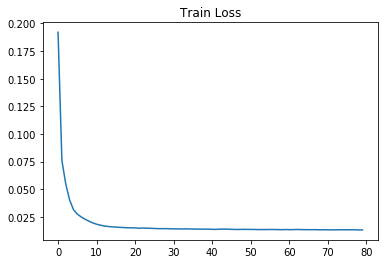

In [437]:
train_losses = np.load('./CW/CAE/train_losses.npy')
plt.plot(list(range(0,train_losses.shape[0])), train_losses)
plt.title('Train Loss')
plt.show()

### Test set reconstruction error

In [438]:
# load the model
model.load_state_dict(torch.load('./CW/CAE/CAE_model.pth'))
model.eval()
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(loader_test):
        img,_ = data
        img = img.to(device)
        recon_batch = model(img)
        test_loss += loss_function_CAE(recon_batch, img)
    # loss calculated over the whole test set
    test_loss /= len(loader_test.dataset)
    print('Test set loss: {:.5f}'.format(test_loss))

Test set loss: 0.00003


### Test set images and reconstructions

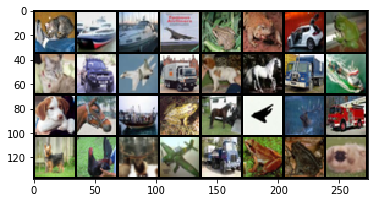

In [439]:
# load the model
model.load_state_dict(torch.load('./CW/CAE/CAE_model.pth'))
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)

show(img)

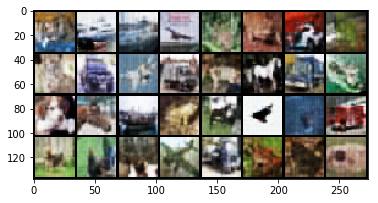

In [440]:
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    recon_batch = model(fixed_input.to(device)).cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    show(recon_batch)

In [441]:
# *CODE FOR PART 1.2 IN THIS CELL*

#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################

###Extract features thanks to the encoder and build the train dataset
X_train, y_train = np.array([[]]), np.array([])
for i, data in enumerate(loader_train):
    img, classes = data
    img = img.to(device)
    img = model.encode(img).view(img.size(0), -1)
    if i == 0:
        X_train = img.cpu().detach().numpy()
    else:
        X_train = np.concatenate((X_train, img.cpu().detach().numpy()), axis=0)
    y_train = np.concatenate((y_train, classes), axis=0)

print(X_train.shape)
print(y_train.shape)

###Extract features thanks to the encoder and build the test dataset
X_test, y_test = np.array([[]]), np.array([])
for i, data in enumerate(loader_test):
    img, classes = data
    img = img.to(device)
    img = model.encode(img).view(img.size(0), -1)
    if i == 0:
        X_test = img.cpu().detach().numpy()
    else:
        X_test = np.concatenate((X_test, img.cpu().detach().numpy()), axis=0)
    y_test = np.concatenate((y_test, classes), axis=0)

print(X_test.shape)
print(y_test.shape)



###Evaluate the classification

    # loss calculated over the whole test set
#######################################################################
#                       ** END OF YOUR CODE **
####################################################################### 


(49000, 256)
(49000,)
(10000, 256)
(10000,)


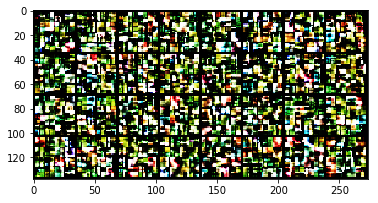

In [518]:
### Try to generate new images from noise test
batch = []

random_features = torch.Tensor(65536).data.normal_(0, 0.5)
recon_batch = model.decode(random_features.view(256, 16, 4, 4).to(device)).cpu().detach().numpy()

recon_batch = recon_batch[0:32, :, :, :]
recon_batch = make_grid(denorm(torch.Tensor(recon_batch)), nrow=8, padding=2, normalize=False,
                        range=None, scale_each=False, pad_value=0)
show(recon_batch)


We can see that the encoder part have learnt some kind of textures.

In [444]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=-1, random_state=0)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.3903


## Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures, tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). 

### Hyper-parameter selection

In [498]:
# *CODE FOR PART 2.1 IN THIS CELL*

### Choose the number of epoch, the learning rate
#   and the size of the Generator's input noise vetor.
num_epochs = 100
learning_rate  = 0.0002 
latent_vector_size = 100
###

# Define here other hyperparameters that you used.


In [499]:
# *CODE FOR PART 2.1 IN THIS CELL*

def make_conv_sig_final(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return [
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,  stride=stride, padding=padding, bias=False),
        nn.Sigmoid()]

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.up1 = nn.Sequential(
            *make_transconv_bn_relu(latent_vector_size, 256, kernel_size=4, stride=1, padding=0))
        
        self.up2 = nn.Sequential(
            *make_transconv_bn_relu(256, 128, kernel_size=4, stride=2, padding=1))
        
        self.up3 = nn.Sequential(
            *make_transconv_bn_relu(128, 64, kernel_size=4, stride=2, padding=1))

        self.up4 = nn.Sequential(
            *make_transconv_tanh_final(64, 3, kernel_size=4, stride=2, padding=1))


    def decode(self, z):

        #print(z.size())
        z=self.up1(z)
        #print(z.size())
        z=self.up2(z)
        #print(z.size())
        z=self.up3(z)
        #print(z.size())
        z=self.up4(z)
        #print(z.size())

        return z

    def forward(self, z):
        return self.decode(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.down1 = nn.Sequential(
            *make_conv_bn_relu(3, 64, kernel_size=4, stride=2, padding=1))
        
        self.down2 = nn.Sequential(
            *make_conv_bn_relu(64, 128, kernel_size=4, stride=2, padding=1))
        
        self.down3 = nn.Sequential(
            *make_conv_bn_relu(128, 256, kernel_size=4, stride=2, padding=1 ))
        
        self.down4 = nn.Sequential(
            *make_conv_sig_final(256, 1, kernel_size=4, stride=1, padding=0))

        
    def discriminator(self, x):

        #print(x.size())
        x=self.down1(x)
        #print(x.size())
        x=self.down2(x)
        #print(x.size())
        x=self.down3(x)
        #print(x.size())
        out=self.down4(x)
        #print(out.size())

        
        return out

    def forward(self, x):
        out = self.discriminator(x)
        return out.view(-1, 1).squeeze(1)

### Initialize Model and print number of parameters

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [500]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [501]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 1068928
Generator(
  (up1): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (up2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (up3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (up4): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Tanh()
  )
)


Total number of parameters in Discriminator is: 663424
Discriminator(
  (down1): Sequential(
    (0): Conv2

### Define loss function

In [502]:
criterion = nn.BCELoss()
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Choose and initialize optimizers

In [503]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))

### Define fixed input vectors to monitor training and mode collapse.

In [504]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

### Train

In [505]:
export_folder = './CW/DCGAN'
train_losses_G = []
train_losses_D = []

for epoch in range(num_epochs):
    for i, data in enumerate(loader_train, 0):
        train_loss_D = 0
        train_loss_G = 0
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(loader_train),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()), './CW/DCGAN/real_samples.png')
    
    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()), './CW/DCGAN/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
            
# save losses and models
np.save('./CW/DCGAN/train_losses_D.npy', np.array(train_losses_D))
np.save('./CW/DCGAN/train_losses_G.npy', np.array(train_losses_G))
torch.save(model_G.state_dict(), './CW/DCGAN/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), './CW/DCGAN/DCGAN_model_D.pth')

[0/100][0/96] Loss_D: 1.8783 Loss_G: 1.6170 D(x): 0.4671 D(G(z)): 0.6125 / 0.2302
[0/100][1/96] Loss_D: 1.5464 Loss_G: 1.7899 D(x): 0.6163 D(G(z)): 0.6059 / 0.1976
[0/100][2/96] Loss_D: 1.3667 Loss_G: 2.0618 D(x): 0.6618 D(G(z)): 0.5608 / 0.1557
[0/100][3/96] Loss_D: 1.1533 Loss_G: 2.4275 D(x): 0.6686 D(G(z)): 0.4724 / 0.1099
[0/100][4/96] Loss_D: 0.9740 Loss_G: 2.6942 D(x): 0.6986 D(G(z)): 0.4055 / 0.0838
[0/100][5/96] Loss_D: 0.9050 Loss_G: 2.9212 D(x): 0.7194 D(G(z)): 0.3852 / 0.0654
[0/100][6/96] Loss_D: 0.7872 Loss_G: 3.1949 D(x): 0.7426 D(G(z)): 0.3380 / 0.0519
[0/100][7/96] Loss_D: 0.7170 Loss_G: 3.3764 D(x): 0.7683 D(G(z)): 0.3160 / 0.0430
[0/100][8/96] Loss_D: 0.7494 Loss_G: 3.5081 D(x): 0.7481 D(G(z)): 0.3077 / 0.0374
[0/100][9/96] Loss_D: 0.6691 Loss_G: 3.7792 D(x): 0.7925 D(G(z)): 0.3068 / 0.0286
[0/100][10/96] Loss_D: 0.5807 Loss_G: 4.0403 D(x): 0.7888 D(G(z)): 0.2325 / 0.0229
[0/100][11/96] Loss_D: 0.5436 Loss_G: 4.1071 D(x): 0.7996 D(G(z)): 0.2213 / 0.0215
[0/100][12/96]

[2/100][4/96] Loss_D: 0.1564 Loss_G: 4.8158 D(x): 0.9185 D(G(z)): 0.0602 / 0.0100
[2/100][5/96] Loss_D: 0.1852 Loss_G: 4.8284 D(x): 0.9118 D(G(z)): 0.0733 / 0.0101
[2/100][6/96] Loss_D: 0.1600 Loss_G: 4.8614 D(x): 0.9207 D(G(z)): 0.0655 / 0.0097
[2/100][7/96] Loss_D: 0.1748 Loss_G: 4.6900 D(x): 0.9115 D(G(z)): 0.0660 / 0.0116
[2/100][8/96] Loss_D: 0.1960 Loss_G: 4.6609 D(x): 0.9057 D(G(z)): 0.0746 / 0.0119
[2/100][9/96] Loss_D: 0.1782 Loss_G: 5.2398 D(x): 0.9229 D(G(z)): 0.0832 / 0.0073
[2/100][10/96] Loss_D: 0.1596 Loss_G: 4.4248 D(x): 0.9034 D(G(z)): 0.0411 / 0.0153
[2/100][11/96] Loss_D: 0.1888 Loss_G: 5.2323 D(x): 0.9287 D(G(z)): 0.0966 / 0.0072
[2/100][12/96] Loss_D: 0.1426 Loss_G: 4.8291 D(x): 0.9181 D(G(z)): 0.0434 / 0.0111
[2/100][13/96] Loss_D: 0.1367 Loss_G: 4.8311 D(x): 0.9381 D(G(z)): 0.0625 / 0.0107
[2/100][14/96] Loss_D: 0.1479 Loss_G: 4.9798 D(x): 0.9287 D(G(z)): 0.0622 / 0.0099
[2/100][15/96] Loss_D: 0.1282 Loss_G: 5.0996 D(x): 0.9380 D(G(z)): 0.0549 / 0.0086
[2/100][16

[4/100][8/96] Loss_D: 0.1408 Loss_G: 5.0600 D(x): 0.9497 D(G(z)): 0.0775 / 0.0097
[4/100][9/96] Loss_D: 0.1496 Loss_G: 4.6876 D(x): 0.9183 D(G(z)): 0.0470 / 0.0141
[4/100][10/96] Loss_D: 0.1439 Loss_G: 5.0137 D(x): 0.9470 D(G(z)): 0.0747 / 0.0105
[4/100][11/96] Loss_D: 0.1243 Loss_G: 4.8524 D(x): 0.9375 D(G(z)): 0.0480 / 0.0113
[4/100][12/96] Loss_D: 0.1125 Loss_G: 4.9104 D(x): 0.9493 D(G(z)): 0.0528 / 0.0114
[4/100][13/96] Loss_D: 0.1278 Loss_G: 4.8708 D(x): 0.9428 D(G(z)): 0.0585 / 0.0120
[4/100][14/96] Loss_D: 0.1386 Loss_G: 4.4863 D(x): 0.9247 D(G(z)): 0.0469 / 0.0175
[4/100][15/96] Loss_D: 0.1396 Loss_G: 4.9884 D(x): 0.9514 D(G(z)): 0.0781 / 0.0108
[4/100][16/96] Loss_D: 0.1305 Loss_G: 4.7396 D(x): 0.9318 D(G(z)): 0.0491 / 0.0145
[4/100][17/96] Loss_D: 0.1488 Loss_G: 4.4182 D(x): 0.9290 D(G(z)): 0.0633 / 0.0191
[4/100][18/96] Loss_D: 0.2042 Loss_G: 5.3564 D(x): 0.9347 D(G(z)): 0.1137 / 0.0092
[4/100][19/96] Loss_D: 0.2010 Loss_G: 3.8716 D(x): 0.8793 D(G(z)): 0.0433 / 0.0327
[4/100

[6/100][12/96] Loss_D: 1.4187 Loss_G: 4.7781 D(x): 0.4550 D(G(z)): 0.0017 / 0.0265
[6/100][13/96] Loss_D: 0.2415 Loss_G: 4.8334 D(x): 0.9934 D(G(z)): 0.1774 / 0.0230
[6/100][14/96] Loss_D: 0.2454 Loss_G: 7.5540 D(x): 0.9904 D(G(z)): 0.1748 / 0.0018
[6/100][15/96] Loss_D: 0.1588 Loss_G: 6.3288 D(x): 0.9022 D(G(z)): 0.0204 / 0.0050
[6/100][16/96] Loss_D: 0.1060 Loss_G: 4.8409 D(x): 0.9476 D(G(z)): 0.0387 / 0.0167
[6/100][17/96] Loss_D: 0.2542 Loss_G: 6.7012 D(x): 0.9667 D(G(z)): 0.1630 / 0.0026
[6/100][18/96] Loss_D: 0.2438 Loss_G: 4.8729 D(x): 0.8502 D(G(z)): 0.0166 / 0.0160
[6/100][19/96] Loss_D: 0.1626 Loss_G: 4.9591 D(x): 0.9603 D(G(z)): 0.0969 / 0.0136
[6/100][20/96] Loss_D: 0.1234 Loss_G: 6.0247 D(x): 0.9736 D(G(z)): 0.0828 / 0.0050
[6/100][21/96] Loss_D: 0.1091 Loss_G: 5.5842 D(x): 0.9426 D(G(z)): 0.0365 / 0.0081
[6/100][22/96] Loss_D: 0.1270 Loss_G: 5.1679 D(x): 0.9535 D(G(z)): 0.0595 / 0.0124
[6/100][23/96] Loss_D: 0.1607 Loss_G: 4.9837 D(x): 0.9351 D(G(z)): 0.0668 / 0.0126
[6/1

[8/100][16/96] Loss_D: 0.1175 Loss_G: 4.5479 D(x): 0.9226 D(G(z)): 0.0240 / 0.0178
[8/100][17/96] Loss_D: 0.0926 Loss_G: 5.2510 D(x): 0.9710 D(G(z)): 0.0565 / 0.0093
[8/100][18/96] Loss_D: 0.1006 Loss_G: 4.9720 D(x): 0.9472 D(G(z)): 0.0373 / 0.0117
[8/100][19/96] Loss_D: 0.1114 Loss_G: 4.9141 D(x): 0.9488 D(G(z)): 0.0491 / 0.0125
[8/100][20/96] Loss_D: 0.1285 Loss_G: 4.7984 D(x): 0.9387 D(G(z)): 0.0519 / 0.0141
[8/100][21/96] Loss_D: 0.1263 Loss_G: 4.5311 D(x): 0.9342 D(G(z)): 0.0479 / 0.0188
[8/100][22/96] Loss_D: 0.1486 Loss_G: 5.8849 D(x): 0.9450 D(G(z)): 0.0777 / 0.0059
[8/100][23/96] Loss_D: 0.1615 Loss_G: 3.6113 D(x): 0.8858 D(G(z)): 0.0184 / 0.0556
[8/100][24/96] Loss_D: 0.2138 Loss_G: 9.0995 D(x): 0.9790 D(G(z)): 0.1559 / 0.0006
[8/100][25/96] Loss_D: 0.5474 Loss_G: 1.1892 D(x): 0.6630 D(G(z)): 0.0019 / 0.3946
[8/100][26/96] Loss_D: 1.2861 Loss_G: 17.6829 D(x): 0.9965 D(G(z)): 0.6157 / 0.0000
[8/100][27/96] Loss_D: 6.0987 Loss_G: 10.0287 D(x): 0.0357 D(G(z)): 0.0000 / 0.0013
[8

[10/100][20/96] Loss_D: 0.0554 Loss_G: 5.7920 D(x): 0.9648 D(G(z)): 0.0164 / 0.0057
[10/100][21/96] Loss_D: 0.0650 Loss_G: 4.7571 D(x): 0.9570 D(G(z)): 0.0172 / 0.0154
[10/100][22/96] Loss_D: 0.0553 Loss_G: 4.6813 D(x): 0.9820 D(G(z)): 0.0347 / 0.0170
[10/100][23/96] Loss_D: 0.0910 Loss_G: 4.7989 D(x): 0.9640 D(G(z)): 0.0468 / 0.0163
[10/100][24/96] Loss_D: 0.0968 Loss_G: 4.5168 D(x): 0.9477 D(G(z)): 0.0354 / 0.0219
[10/100][25/96] Loss_D: 0.0888 Loss_G: 4.6193 D(x): 0.9627 D(G(z)): 0.0460 / 0.0193
[10/100][26/96] Loss_D: 0.0857 Loss_G: 5.3570 D(x): 0.9763 D(G(z)): 0.0529 / 0.0105
[10/100][27/96] Loss_D: 0.1128 Loss_G: 4.3520 D(x): 0.9314 D(G(z)): 0.0313 / 0.0266
[10/100][28/96] Loss_D: 0.1355 Loss_G: 4.6923 D(x): 0.9506 D(G(z)): 0.0728 / 0.0186
[10/100][29/96] Loss_D: 0.1247 Loss_G: 4.3686 D(x): 0.9339 D(G(z)): 0.0471 / 0.0254
[10/100][30/96] Loss_D: 0.1298 Loss_G: 4.4944 D(x): 0.9449 D(G(z)): 0.0630 / 0.0226
[10/100][31/96] Loss_D: 0.1273 Loss_G: 4.7594 D(x): 0.9463 D(G(z)): 0.0617 /

[12/100][22/96] Loss_D: 0.5601 Loss_G: 3.3559 D(x): 0.8978 D(G(z)): 0.2389 / 0.0742
[12/100][23/96] Loss_D: 0.3046 Loss_G: 5.1669 D(x): 0.9347 D(G(z)): 0.1738 / 0.0119
[12/100][24/96] Loss_D: 0.2080 Loss_G: 4.2695 D(x): 0.8658 D(G(z)): 0.0247 / 0.0262
[12/100][25/96] Loss_D: 0.2021 Loss_G: 3.2515 D(x): 0.9093 D(G(z)): 0.0809 / 0.0647
[12/100][26/96] Loss_D: 0.2409 Loss_G: 4.1446 D(x): 0.9501 D(G(z)): 0.1526 / 0.0275
[12/100][27/96] Loss_D: 0.1813 Loss_G: 3.9444 D(x): 0.8963 D(G(z)): 0.0586 / 0.0328
[12/100][28/96] Loss_D: 0.1978 Loss_G: 3.5726 D(x): 0.9121 D(G(z)): 0.0873 / 0.0440
[12/100][29/96] Loss_D: 0.1978 Loss_G: 4.2788 D(x): 0.9466 D(G(z)): 0.1221 / 0.0217
[12/100][30/96] Loss_D: 0.1438 Loss_G: 4.1827 D(x): 0.9170 D(G(z)): 0.0477 / 0.0238
[12/100][31/96] Loss_D: 0.2366 Loss_G: 3.3668 D(x): 0.8781 D(G(z)): 0.0817 / 0.0599
[12/100][32/96] Loss_D: 0.1953 Loss_G: 4.1568 D(x): 0.9452 D(G(z)): 0.1192 / 0.0253
[12/100][33/96] Loss_D: 0.1983 Loss_G: 4.0383 D(x): 0.9111 D(G(z)): 0.0868 /

[14/100][24/96] Loss_D: 0.3498 Loss_G: 1.8440 D(x): 0.8014 D(G(z)): 0.0931 / 0.2103
[14/100][25/96] Loss_D: 0.4058 Loss_G: 4.5284 D(x): 0.9374 D(G(z)): 0.2635 / 0.0184
[14/100][26/96] Loss_D: 0.5219 Loss_G: 1.2876 D(x): 0.6645 D(G(z)): 0.0349 / 0.3516
[14/100][27/96] Loss_D: 0.6560 Loss_G: 5.8439 D(x): 0.9726 D(G(z)): 0.4022 / 0.0075
[14/100][28/96] Loss_D: 0.9324 Loss_G: 1.2542 D(x): 0.4759 D(G(z)): 0.0146 / 0.3734
[14/100][29/96] Loss_D: 0.7717 Loss_G: 6.0896 D(x): 0.9871 D(G(z)): 0.4640 / 0.0047
[14/100][30/96] Loss_D: 0.9442 Loss_G: 0.9288 D(x): 0.4784 D(G(z)): 0.0080 / 0.4746
[14/100][31/96] Loss_D: 1.1417 Loss_G: 6.1935 D(x): 0.9930 D(G(z)): 0.5924 / 0.0088
[14/100][32/96] Loss_D: 1.0131 Loss_G: 0.7081 D(x): 0.4729 D(G(z)): 0.0279 / 0.5650
[14/100][33/96] Loss_D: 1.4206 Loss_G: 7.4937 D(x): 0.9676 D(G(z)): 0.6566 / 0.0020
[14/100][34/96] Loss_D: 1.9895 Loss_G: 1.1131 D(x): 0.2195 D(G(z)): 0.0054 / 0.4437
[14/100][35/96] Loss_D: 1.3350 Loss_G: 4.6588 D(x): 0.9808 D(G(z)): 0.6232 /

[16/100][26/96] Loss_D: 0.3900 Loss_G: 2.8967 D(x): 0.9190 D(G(z)): 0.2432 / 0.0760
[16/100][27/96] Loss_D: 0.4204 Loss_G: 2.0817 D(x): 0.7744 D(G(z)): 0.1269 / 0.1565
[16/100][28/96] Loss_D: 0.3419 Loss_G: 2.7088 D(x): 0.8816 D(G(z)): 0.1772 / 0.0888
[16/100][29/96] Loss_D: 0.3722 Loss_G: 1.9898 D(x): 0.7981 D(G(z)): 0.1139 / 0.1706
[16/100][30/96] Loss_D: 0.3756 Loss_G: 3.2121 D(x): 0.9075 D(G(z)): 0.2206 / 0.0584
[16/100][31/96] Loss_D: 0.4088 Loss_G: 1.8033 D(x): 0.7412 D(G(z)): 0.0745 / 0.2051
[16/100][32/96] Loss_D: 0.3917 Loss_G: 2.6544 D(x): 0.8990 D(G(z)): 0.2288 / 0.0934
[16/100][33/96] Loss_D: 0.3614 Loss_G: 2.4625 D(x): 0.8308 D(G(z)): 0.1452 / 0.1085
[16/100][34/96] Loss_D: 0.3350 Loss_G: 2.1676 D(x): 0.8366 D(G(z)): 0.1291 / 0.1408
[16/100][35/96] Loss_D: 0.3431 Loss_G: 2.8725 D(x): 0.8908 D(G(z)): 0.1867 / 0.0756
[16/100][36/96] Loss_D: 0.3223 Loss_G: 2.1639 D(x): 0.8074 D(G(z)): 0.0867 / 0.1442
[16/100][37/96] Loss_D: 0.3691 Loss_G: 2.8533 D(x): 0.8983 D(G(z)): 0.2121 /

[18/100][28/96] Loss_D: 3.3433 Loss_G: 1.1543 D(x): 0.1024 D(G(z)): 0.0175 / 0.4145
[18/100][29/96] Loss_D: 1.5306 Loss_G: 2.9497 D(x): 0.8439 D(G(z)): 0.6324 / 0.1160
[18/100][30/96] Loss_D: 0.8876 Loss_G: 2.6262 D(x): 0.6338 D(G(z)): 0.2207 / 0.1132
[18/100][31/96] Loss_D: 0.6627 Loss_G: 2.0466 D(x): 0.7276 D(G(z)): 0.2282 / 0.1847
[18/100][32/96] Loss_D: 0.9173 Loss_G: 3.6930 D(x): 0.8301 D(G(z)): 0.4401 / 0.0500
[18/100][33/96] Loss_D: 0.9946 Loss_G: 1.5373 D(x): 0.5232 D(G(z)): 0.1528 / 0.2817
[18/100][34/96] Loss_D: 0.9829 Loss_G: 4.0518 D(x): 0.8494 D(G(z)): 0.4835 / 0.0325
[18/100][35/96] Loss_D: 0.7745 Loss_G: 2.0976 D(x): 0.5661 D(G(z)): 0.0805 / 0.1855
[18/100][36/96] Loss_D: 0.6548 Loss_G: 3.4100 D(x): 0.8915 D(G(z)): 0.3632 / 0.0542
[18/100][37/96] Loss_D: 0.5775 Loss_G: 2.6487 D(x): 0.7086 D(G(z)): 0.1511 / 0.1030
[18/100][38/96] Loss_D: 0.4968 Loss_G: 3.3451 D(x): 0.8782 D(G(z)): 0.2654 / 0.0571
[18/100][39/96] Loss_D: 0.7990 Loss_G: 2.3425 D(x): 0.6753 D(G(z)): 0.2613 /

[20/100][30/96] Loss_D: 0.4187 Loss_G: 2.1889 D(x): 0.7616 D(G(z)): 0.1071 / 0.1450
[20/100][31/96] Loss_D: 0.3736 Loss_G: 2.4517 D(x): 0.8814 D(G(z)): 0.2012 / 0.1141
[20/100][32/96] Loss_D: 0.3745 Loss_G: 2.2810 D(x): 0.8182 D(G(z)): 0.1391 / 0.1344
[20/100][33/96] Loss_D: 0.3889 Loss_G: 2.4060 D(x): 0.8468 D(G(z)): 0.1761 / 0.1190
[20/100][34/96] Loss_D: 0.3864 Loss_G: 2.4965 D(x): 0.8385 D(G(z)): 0.1654 / 0.1102
[20/100][35/96] Loss_D: 0.3838 Loss_G: 2.4512 D(x): 0.8343 D(G(z)): 0.1605 / 0.1175
[20/100][36/96] Loss_D: 0.3731 Loss_G: 2.2984 D(x): 0.8327 D(G(z)): 0.1529 / 0.1338
[20/100][37/96] Loss_D: 0.3822 Loss_G: 2.5748 D(x): 0.8560 D(G(z)): 0.1828 / 0.1030
[20/100][38/96] Loss_D: 0.4866 Loss_G: 2.0381 D(x): 0.7792 D(G(z)): 0.1752 / 0.1692
[20/100][39/96] Loss_D: 0.4136 Loss_G: 2.4620 D(x): 0.8512 D(G(z)): 0.2019 / 0.1126
[20/100][40/96] Loss_D: 0.3932 Loss_G: 2.1644 D(x): 0.8096 D(G(z)): 0.1411 / 0.1465
[20/100][41/96] Loss_D: 0.3870 Loss_G: 2.4976 D(x): 0.8546 D(G(z)): 0.1821 /

[22/100][32/96] Loss_D: 0.5976 Loss_G: 1.6172 D(x): 0.6694 D(G(z)): 0.1366 / 0.2397
[22/100][33/96] Loss_D: 0.5477 Loss_G: 2.2427 D(x): 0.8445 D(G(z)): 0.2875 / 0.1326
[22/100][34/96] Loss_D: 0.5221 Loss_G: 1.9397 D(x): 0.7390 D(G(z)): 0.1674 / 0.1821
[22/100][35/96] Loss_D: 0.4733 Loss_G: 2.1641 D(x): 0.8294 D(G(z)): 0.2232 / 0.1449
[22/100][36/96] Loss_D: 0.5214 Loss_G: 2.2086 D(x): 0.7850 D(G(z)): 0.2173 / 0.1404
[22/100][37/96] Loss_D: 0.5164 Loss_G: 1.6444 D(x): 0.7492 D(G(z)): 0.1710 / 0.2273
[22/100][38/96] Loss_D: 0.5120 Loss_G: 2.6281 D(x): 0.8626 D(G(z)): 0.2817 / 0.0904
[22/100][39/96] Loss_D: 0.5506 Loss_G: 1.4666 D(x): 0.6752 D(G(z)): 0.1062 / 0.2707
[22/100][40/96] Loss_D: 0.5947 Loss_G: 2.8108 D(x): 0.8780 D(G(z)): 0.3432 / 0.0817
[22/100][41/96] Loss_D: 0.4994 Loss_G: 1.8637 D(x): 0.7107 D(G(z)): 0.1114 / 0.1919
[22/100][42/96] Loss_D: 0.4251 Loss_G: 2.1795 D(x): 0.8591 D(G(z)): 0.2190 / 0.1405
[22/100][43/96] Loss_D: 0.4603 Loss_G: 2.2320 D(x): 0.8085 D(G(z)): 0.1984 /

[24/100][34/96] Loss_D: 0.5557 Loss_G: 2.7609 D(x): 0.8492 D(G(z)): 0.2980 / 0.0818
[24/100][35/96] Loss_D: 0.6312 Loss_G: 1.1685 D(x): 0.6316 D(G(z)): 0.1080 / 0.3592
[24/100][36/96] Loss_D: 0.7598 Loss_G: 3.7565 D(x): 0.9231 D(G(z)): 0.4513 / 0.0350
[24/100][37/96] Loss_D: 1.1275 Loss_G: 0.6804 D(x): 0.3851 D(G(z)): 0.0491 / 0.5530
[24/100][38/96] Loss_D: 1.2168 Loss_G: 4.3945 D(x): 0.9638 D(G(z)): 0.6348 / 0.0221
[24/100][39/96] Loss_D: 1.3735 Loss_G: 0.1641 D(x): 0.3213 D(G(z)): 0.0400 / 0.8626
[24/100][40/96] Loss_D: 2.6566 Loss_G: 5.5425 D(x): 0.9806 D(G(z)): 0.8845 / 0.0086
[24/100][41/96] Loss_D: 2.3091 Loss_G: 1.0956 D(x): 0.1563 D(G(z)): 0.0204 / 0.4002
[24/100][42/96] Loss_D: 0.8912 Loss_G: 2.1128 D(x): 0.8879 D(G(z)): 0.4695 / 0.1638
[24/100][43/96] Loss_D: 0.6621 Loss_G: 2.0459 D(x): 0.7189 D(G(z)): 0.2333 / 0.1685
[24/100][44/96] Loss_D: 0.7807 Loss_G: 1.4533 D(x): 0.6767 D(G(z)): 0.2677 / 0.2769
[24/100][45/96] Loss_D: 0.7353 Loss_G: 2.8076 D(x): 0.8255 D(G(z)): 0.3816 /

[26/100][36/96] Loss_D: 0.7740 Loss_G: 1.0711 D(x): 0.5595 D(G(z)): 0.1083 / 0.3835
[26/100][37/96] Loss_D: 0.7481 Loss_G: 3.2700 D(x): 0.9087 D(G(z)): 0.4446 / 0.0527
[26/100][38/96] Loss_D: 0.9712 Loss_G: 0.7786 D(x): 0.4638 D(G(z)): 0.0911 / 0.4964
[26/100][39/96] Loss_D: 0.9097 Loss_G: 3.4981 D(x): 0.9319 D(G(z)): 0.5296 / 0.0421
[26/100][40/96] Loss_D: 0.9569 Loss_G: 0.9502 D(x): 0.4624 D(G(z)): 0.0795 / 0.4271
[26/100][41/96] Loss_D: 0.7995 Loss_G: 2.9948 D(x): 0.9214 D(G(z)): 0.4694 / 0.0674
[26/100][42/96] Loss_D: 0.6890 Loss_G: 1.5516 D(x): 0.6131 D(G(z)): 0.1282 / 0.2506
[26/100][43/96] Loss_D: 0.6336 Loss_G: 1.9954 D(x): 0.8253 D(G(z)): 0.3295 / 0.1648
[26/100][44/96] Loss_D: 0.6164 Loss_G: 1.7868 D(x): 0.7186 D(G(z)): 0.2153 / 0.2059
[26/100][45/96] Loss_D: 0.6897 Loss_G: 1.8583 D(x): 0.7507 D(G(z)): 0.2960 / 0.1888
[26/100][46/96] Loss_D: 0.6857 Loss_G: 1.9263 D(x): 0.7364 D(G(z)): 0.2805 / 0.1744
[26/100][47/96] Loss_D: 0.7091 Loss_G: 1.4795 D(x): 0.6762 D(G(z)): 0.2376 /

[28/100][38/96] Loss_D: 1.0444 Loss_G: 0.9266 D(x): 0.4367 D(G(z)): 0.0960 / 0.4413
[28/100][39/96] Loss_D: 1.0526 Loss_G: 2.8771 D(x): 0.8823 D(G(z)): 0.5581 / 0.0793
[28/100][40/96] Loss_D: 0.9623 Loss_G: 1.0299 D(x): 0.4756 D(G(z)): 0.1210 / 0.3987
[28/100][41/96] Loss_D: 0.7970 Loss_G: 2.7842 D(x): 0.8842 D(G(z)): 0.4552 / 0.0844
[28/100][42/96] Loss_D: 0.8074 Loss_G: 1.2791 D(x): 0.5507 D(G(z)): 0.1256 / 0.3252
[28/100][43/96] Loss_D: 0.7726 Loss_G: 2.4947 D(x): 0.8765 D(G(z)): 0.4359 / 0.1072
[28/100][44/96] Loss_D: 0.7122 Loss_G: 1.5420 D(x): 0.6249 D(G(z)): 0.1668 / 0.2486
[28/100][45/96] Loss_D: 0.6976 Loss_G: 1.8803 D(x): 0.7893 D(G(z)): 0.3341 / 0.1868
[28/100][46/96] Loss_D: 0.7423 Loss_G: 1.3061 D(x): 0.6415 D(G(z)): 0.2163 / 0.3106
[28/100][47/96] Loss_D: 0.7097 Loss_G: 2.4674 D(x): 0.8474 D(G(z)): 0.3884 / 0.1073
[28/100][48/96] Loss_D: 0.8386 Loss_G: 1.0266 D(x): 0.5487 D(G(z)): 0.1531 / 0.3997
[28/100][49/96] Loss_D: 0.8936 Loss_G: 2.8787 D(x): 0.8821 D(G(z)): 0.4976 /

[30/100][40/96] Loss_D: 1.0515 Loss_G: 2.7560 D(x): 0.8974 D(G(z)): 0.5675 / 0.0872
[30/100][41/96] Loss_D: 0.8836 Loss_G: 1.2419 D(x): 0.5169 D(G(z)): 0.1251 / 0.3310
[30/100][42/96] Loss_D: 0.8535 Loss_G: 2.1380 D(x): 0.8205 D(G(z)): 0.4354 / 0.1471
[30/100][43/96] Loss_D: 0.7318 Loss_G: 1.5386 D(x): 0.6531 D(G(z)): 0.2198 / 0.2521
[30/100][44/96] Loss_D: 0.7170 Loss_G: 2.1430 D(x): 0.7898 D(G(z)): 0.3494 / 0.1435
[30/100][45/96] Loss_D: 0.7503 Loss_G: 1.2908 D(x): 0.6166 D(G(z)): 0.1910 / 0.3141
[30/100][46/96] Loss_D: 0.8049 Loss_G: 2.2329 D(x): 0.7886 D(G(z)): 0.3992 / 0.1293
[30/100][47/96] Loss_D: 0.7898 Loss_G: 1.3184 D(x): 0.6097 D(G(z)): 0.2126 / 0.3013
[30/100][48/96] Loss_D: 0.7289 Loss_G: 2.1697 D(x): 0.8063 D(G(z)): 0.3730 / 0.1412
[30/100][49/96] Loss_D: 0.7480 Loss_G: 1.3036 D(x): 0.6072 D(G(z)): 0.1742 / 0.3146
[30/100][50/96] Loss_D: 0.7885 Loss_G: 2.6897 D(x): 0.8445 D(G(z)): 0.4293 / 0.0847
[30/100][51/96] Loss_D: 0.8382 Loss_G: 1.0748 D(x): 0.5401 D(G(z)): 0.1408 /

[32/100][42/96] Loss_D: 0.7831 Loss_G: 1.9143 D(x): 0.7449 D(G(z)): 0.3456 / 0.1844
[32/100][43/96] Loss_D: 0.8149 Loss_G: 1.6691 D(x): 0.6653 D(G(z)): 0.2928 / 0.2192
[32/100][44/96] Loss_D: 0.7645 Loss_G: 1.5714 D(x): 0.6858 D(G(z)): 0.2810 / 0.2422
[32/100][45/96] Loss_D: 0.6599 Loss_G: 2.0414 D(x): 0.7749 D(G(z)): 0.3045 / 0.1573
[32/100][46/96] Loss_D: 0.6984 Loss_G: 1.6243 D(x): 0.6877 D(G(z)): 0.2429 / 0.2276
[32/100][47/96] Loss_D: 0.6672 Loss_G: 1.8742 D(x): 0.7532 D(G(z)): 0.2870 / 0.1863
[32/100][48/96] Loss_D: 0.7392 Loss_G: 1.5799 D(x): 0.6899 D(G(z)): 0.2667 / 0.2428
[32/100][49/96] Loss_D: 0.6814 Loss_G: 1.8213 D(x): 0.7528 D(G(z)): 0.3003 / 0.1897
[32/100][50/96] Loss_D: 0.6662 Loss_G: 1.6057 D(x): 0.6967 D(G(z)): 0.2265 / 0.2359
[32/100][51/96] Loss_D: 0.6476 Loss_G: 2.0842 D(x): 0.7863 D(G(z)): 0.3047 / 0.1507
[32/100][52/96] Loss_D: 0.7262 Loss_G: 1.3974 D(x): 0.6513 D(G(z)): 0.2191 / 0.2811
[32/100][53/96] Loss_D: 0.7164 Loss_G: 2.1562 D(x): 0.7947 D(G(z)): 0.3541 /

[34/100][44/96] Loss_D: 0.6483 Loss_G: 1.4611 D(x): 0.7019 D(G(z)): 0.2239 / 0.2671
[34/100][45/96] Loss_D: 0.6547 Loss_G: 2.4644 D(x): 0.8292 D(G(z)): 0.3459 / 0.1067
[34/100][46/96] Loss_D: 0.7588 Loss_G: 0.9622 D(x): 0.5691 D(G(z)): 0.1279 / 0.4192
[34/100][47/96] Loss_D: 0.8435 Loss_G: 3.0833 D(x): 0.8942 D(G(z)): 0.4785 / 0.0623
[34/100][48/96] Loss_D: 0.9795 Loss_G: 0.7529 D(x): 0.4532 D(G(z)): 0.0940 / 0.5100
[34/100][49/96] Loss_D: 0.8942 Loss_G: 2.9477 D(x): 0.9050 D(G(z)): 0.5118 / 0.0699
[34/100][50/96] Loss_D: 0.8815 Loss_G: 0.7890 D(x): 0.5039 D(G(z)): 0.1137 / 0.4917
[34/100][51/96] Loss_D: 0.9670 Loss_G: 3.1590 D(x): 0.8958 D(G(z)): 0.5387 / 0.0555
[34/100][52/96] Loss_D: 1.0552 Loss_G: 0.8142 D(x): 0.4113 D(G(z)): 0.0716 / 0.4814
[34/100][53/96] Loss_D: 0.9965 Loss_G: 2.9308 D(x): 0.8995 D(G(z)): 0.5478 / 0.0768
[34/100][54/96] Loss_D: 1.1522 Loss_G: 0.4405 D(x): 0.4022 D(G(z)): 0.1195 / 0.6709
[34/100][55/96] Loss_D: 1.4943 Loss_G: 3.6054 D(x): 0.9179 D(G(z)): 0.7134 /

[36/100][46/96] Loss_D: 0.8153 Loss_G: 1.8248 D(x): 0.7700 D(G(z)): 0.3930 / 0.1914
[36/100][47/96] Loss_D: 0.7832 Loss_G: 1.3769 D(x): 0.6330 D(G(z)): 0.2387 / 0.2857
[36/100][48/96] Loss_D: 0.7071 Loss_G: 1.9841 D(x): 0.7980 D(G(z)): 0.3523 / 0.1660
[36/100][49/96] Loss_D: 0.7261 Loss_G: 1.4128 D(x): 0.6381 D(G(z)): 0.2059 / 0.2780
[36/100][50/96] Loss_D: 0.7920 Loss_G: 1.8099 D(x): 0.7595 D(G(z)): 0.3729 / 0.1910
[36/100][51/96] Loss_D: 0.6756 Loss_G: 1.6627 D(x): 0.6929 D(G(z)): 0.2359 / 0.2178
[36/100][52/96] Loss_D: 0.6691 Loss_G: 1.5487 D(x): 0.7309 D(G(z)): 0.2740 / 0.2381
[36/100][53/96] Loss_D: 0.6617 Loss_G: 1.9037 D(x): 0.7579 D(G(z)): 0.2937 / 0.1754
[36/100][54/96] Loss_D: 0.7163 Loss_G: 1.6203 D(x): 0.6962 D(G(z)): 0.2631 / 0.2330
[36/100][55/96] Loss_D: 0.7578 Loss_G: 1.5730 D(x): 0.6981 D(G(z)): 0.2925 / 0.2433
[36/100][56/96] Loss_D: 0.7356 Loss_G: 1.7674 D(x): 0.7262 D(G(z)): 0.3072 / 0.2029
[36/100][57/96] Loss_D: 0.6734 Loss_G: 1.7595 D(x): 0.7193 D(G(z)): 0.2608 /

[38/100][48/96] Loss_D: 0.8565 Loss_G: 2.3104 D(x): 0.8358 D(G(z)): 0.4518 / 0.1250
[38/100][49/96] Loss_D: 0.7850 Loss_G: 1.5421 D(x): 0.6109 D(G(z)): 0.2066 / 0.2487
[38/100][50/96] Loss_D: 0.8372 Loss_G: 2.0020 D(x): 0.7572 D(G(z)): 0.3846 / 0.1685
[38/100][51/96] Loss_D: 0.8299 Loss_G: 1.5610 D(x): 0.6365 D(G(z)): 0.2614 / 0.2420
[38/100][52/96] Loss_D: 0.7213 Loss_G: 2.0046 D(x): 0.7593 D(G(z)): 0.3293 / 0.1594
[38/100][53/96] Loss_D: 0.8191 Loss_G: 1.3871 D(x): 0.6264 D(G(z)): 0.2468 / 0.2889
[38/100][54/96] Loss_D: 0.7816 Loss_G: 2.0041 D(x): 0.7573 D(G(z)): 0.3618 / 0.1622
[38/100][55/96] Loss_D: 0.6759 Loss_G: 1.6931 D(x): 0.6872 D(G(z)): 0.2275 / 0.2112
[38/100][56/96] Loss_D: 0.6622 Loss_G: 1.6639 D(x): 0.7341 D(G(z)): 0.2708 / 0.2177
[38/100][57/96] Loss_D: 0.7068 Loss_G: 1.9150 D(x): 0.7459 D(G(z)): 0.3096 / 0.1754
[38/100][58/96] Loss_D: 0.6369 Loss_G: 1.7016 D(x): 0.7034 D(G(z)): 0.2197 / 0.2144
[38/100][59/96] Loss_D: 0.6832 Loss_G: 1.5430 D(x): 0.7088 D(G(z)): 0.2568 /

[40/100][50/96] Loss_D: 0.7845 Loss_G: 1.6102 D(x): 0.6917 D(G(z)): 0.3024 / 0.2340
[40/100][51/96] Loss_D: 0.7244 Loss_G: 1.6302 D(x): 0.6983 D(G(z)): 0.2674 / 0.2292
[40/100][52/96] Loss_D: 0.7822 Loss_G: 1.9633 D(x): 0.7342 D(G(z)): 0.3468 / 0.1658
[40/100][53/96] Loss_D: 0.7788 Loss_G: 1.4003 D(x): 0.6374 D(G(z)): 0.2409 / 0.2792
[40/100][54/96] Loss_D: 0.7487 Loss_G: 1.9459 D(x): 0.7764 D(G(z)): 0.3601 / 0.1732
[40/100][55/96] Loss_D: 0.7126 Loss_G: 1.5544 D(x): 0.6736 D(G(z)): 0.2374 / 0.2440
[40/100][56/96] Loss_D: 0.6996 Loss_G: 1.9505 D(x): 0.7731 D(G(z)): 0.3235 / 0.1737
[40/100][57/96] Loss_D: 0.6316 Loss_G: 1.7923 D(x): 0.7230 D(G(z)): 0.2355 / 0.1940
[40/100][58/96] Loss_D: 0.6883 Loss_G: 1.7396 D(x): 0.7273 D(G(z)): 0.2766 / 0.2115
[40/100][59/96] Loss_D: 0.6597 Loss_G: 1.9262 D(x): 0.7593 D(G(z)): 0.2895 / 0.1747
[40/100][60/96] Loss_D: 0.6589 Loss_G: 1.8940 D(x): 0.7390 D(G(z)): 0.2667 / 0.1838
[40/100][61/96] Loss_D: 0.7338 Loss_G: 1.5539 D(x): 0.6969 D(G(z)): 0.2780 /

[42/100][52/96] Loss_D: 0.7092 Loss_G: 1.4090 D(x): 0.6396 D(G(z)): 0.1956 / 0.2829
[42/100][53/96] Loss_D: 0.7238 Loss_G: 2.0203 D(x): 0.7814 D(G(z)): 0.3514 / 0.1569
[42/100][54/96] Loss_D: 0.7101 Loss_G: 1.7848 D(x): 0.6964 D(G(z)): 0.2602 / 0.1979
[42/100][55/96] Loss_D: 0.6804 Loss_G: 1.4817 D(x): 0.6922 D(G(z)): 0.2351 / 0.2572
[42/100][56/96] Loss_D: 0.6949 Loss_G: 2.1270 D(x): 0.7841 D(G(z)): 0.3367 / 0.1427
[42/100][57/96] Loss_D: 0.6772 Loss_G: 1.6390 D(x): 0.6721 D(G(z)): 0.2117 / 0.2209
[42/100][58/96] Loss_D: 0.6114 Loss_G: 1.9256 D(x): 0.7926 D(G(z)): 0.2912 / 0.1720
[42/100][59/96] Loss_D: 0.7764 Loss_G: 1.4504 D(x): 0.6639 D(G(z)): 0.2687 / 0.2678
[42/100][60/96] Loss_D: 0.7155 Loss_G: 2.0992 D(x): 0.7803 D(G(z)): 0.3438 / 0.1475
[42/100][61/96] Loss_D: 0.8305 Loss_G: 1.3001 D(x): 0.5965 D(G(z)): 0.2237 / 0.3085
[42/100][62/96] Loss_D: 0.8145 Loss_G: 2.2313 D(x): 0.7969 D(G(z)): 0.4143 / 0.1283
[42/100][63/96] Loss_D: 0.8128 Loss_G: 1.3544 D(x): 0.5912 D(G(z)): 0.2049 /

[44/100][54/96] Loss_D: 0.9081 Loss_G: 1.0654 D(x): 0.5198 D(G(z)): 0.1713 / 0.3758
[44/100][55/96] Loss_D: 0.7317 Loss_G: 1.8914 D(x): 0.8091 D(G(z)): 0.3761 / 0.1758
[44/100][56/96] Loss_D: 0.7324 Loss_G: 1.7406 D(x): 0.6990 D(G(z)): 0.2799 / 0.2057
[44/100][57/96] Loss_D: 0.7118 Loss_G: 1.5649 D(x): 0.7088 D(G(z)): 0.2764 / 0.2392
[44/100][58/96] Loss_D: 0.6331 Loss_G: 1.6870 D(x): 0.7428 D(G(z)): 0.2609 / 0.2154
[44/100][59/96] Loss_D: 0.6956 Loss_G: 2.0139 D(x): 0.7516 D(G(z)): 0.3065 / 0.1589
[44/100][60/96] Loss_D: 0.7332 Loss_G: 1.2442 D(x): 0.6447 D(G(z)): 0.2215 / 0.3283
[44/100][61/96] Loss_D: 0.7856 Loss_G: 2.5564 D(x): 0.8201 D(G(z)): 0.4147 / 0.0957
[44/100][62/96] Loss_D: 0.8597 Loss_G: 1.0289 D(x): 0.5126 D(G(z)): 0.1153 / 0.3931
[44/100][63/96] Loss_D: 0.8598 Loss_G: 2.7023 D(x): 0.8730 D(G(z)): 0.4826 / 0.0857
[44/100][64/96] Loss_D: 0.8330 Loss_G: 0.8760 D(x): 0.5400 D(G(z)): 0.1438 / 0.4561
[44/100][65/96] Loss_D: 0.9216 Loss_G: 3.0087 D(x): 0.8880 D(G(z)): 0.5186 /

[46/100][56/96] Loss_D: 2.7411 Loss_G: 4.0316 D(x): 0.9598 D(G(z)): 0.9016 / 0.0300
[46/100][57/96] Loss_D: 2.2172 Loss_G: 0.7560 D(x): 0.1550 D(G(z)): 0.0550 / 0.5159
[46/100][58/96] Loss_D: 1.3134 Loss_G: 1.8882 D(x): 0.7992 D(G(z)): 0.6088 / 0.1869
[46/100][59/96] Loss_D: 0.9928 Loss_G: 1.4283 D(x): 0.5449 D(G(z)): 0.2493 / 0.2818
[46/100][60/96] Loss_D: 0.9487 Loss_G: 1.6408 D(x): 0.7136 D(G(z)): 0.4098 / 0.2322
[46/100][61/96] Loss_D: 0.8734 Loss_G: 1.4866 D(x): 0.6442 D(G(z)): 0.3044 / 0.2648
[46/100][62/96] Loss_D: 0.9036 Loss_G: 1.7191 D(x): 0.6945 D(G(z)): 0.3726 / 0.2129
[46/100][63/96] Loss_D: 0.8174 Loss_G: 1.4357 D(x): 0.6477 D(G(z)): 0.2786 / 0.2752
[46/100][64/96] Loss_D: 0.7769 Loss_G: 1.9179 D(x): 0.7585 D(G(z)): 0.3641 / 0.1730
[46/100][65/96] Loss_D: 0.7871 Loss_G: 1.4594 D(x): 0.6551 D(G(z)): 0.2654 / 0.2673
[46/100][66/96] Loss_D: 0.8536 Loss_G: 1.6596 D(x): 0.7034 D(G(z)): 0.3539 / 0.2240
[46/100][67/96] Loss_D: 0.7850 Loss_G: 1.6869 D(x): 0.6915 D(G(z)): 0.3016 /

[48/100][58/96] Loss_D: 0.6571 Loss_G: 1.3196 D(x): 0.6797 D(G(z)): 0.2045 / 0.2968
[48/100][59/96] Loss_D: 0.6687 Loss_G: 2.2987 D(x): 0.8244 D(G(z)): 0.3544 / 0.1230
[48/100][60/96] Loss_D: 0.7187 Loss_G: 1.0822 D(x): 0.5988 D(G(z)): 0.1489 / 0.3744
[48/100][61/96] Loss_D: 0.8561 Loss_G: 2.5045 D(x): 0.8534 D(G(z)): 0.4706 / 0.1028
[48/100][62/96] Loss_D: 0.8323 Loss_G: 1.1274 D(x): 0.5358 D(G(z)): 0.1340 / 0.3551
[48/100][63/96] Loss_D: 0.7966 Loss_G: 2.0852 D(x): 0.8086 D(G(z)): 0.4122 / 0.1508
[48/100][64/96] Loss_D: 0.8024 Loss_G: 1.0720 D(x): 0.5907 D(G(z)): 0.1962 / 0.3748
[48/100][65/96] Loss_D: 0.7910 Loss_G: 2.6392 D(x): 0.8387 D(G(z)): 0.4333 / 0.0866
[48/100][66/96] Loss_D: 0.8926 Loss_G: 0.8850 D(x): 0.5003 D(G(z)): 0.1230 / 0.4474
[48/100][67/96] Loss_D: 0.8974 Loss_G: 2.5316 D(x): 0.8629 D(G(z)): 0.4965 / 0.0983
[48/100][68/96] Loss_D: 0.8773 Loss_G: 0.9949 D(x): 0.5030 D(G(z)): 0.1184 / 0.4078
[48/100][69/96] Loss_D: 0.8057 Loss_G: 2.3871 D(x): 0.8681 D(G(z)): 0.4540 /

[50/100][60/96] Loss_D: 0.7132 Loss_G: 1.2126 D(x): 0.6637 D(G(z)): 0.2327 / 0.3352
[50/100][61/96] Loss_D: 0.8428 Loss_G: 2.3060 D(x): 0.7980 D(G(z)): 0.4293 / 0.1189
[50/100][62/96] Loss_D: 0.9257 Loss_G: 0.8986 D(x): 0.4994 D(G(z)): 0.1525 / 0.4374
[50/100][63/96] Loss_D: 0.9279 Loss_G: 2.2769 D(x): 0.8476 D(G(z)): 0.4996 / 0.1277
[50/100][64/96] Loss_D: 0.7796 Loss_G: 1.3443 D(x): 0.5788 D(G(z)): 0.1636 / 0.2930
[50/100][65/96] Loss_D: 0.7308 Loss_G: 1.7780 D(x): 0.7965 D(G(z)): 0.3690 / 0.1948
[50/100][66/96] Loss_D: 0.7478 Loss_G: 1.6812 D(x): 0.6891 D(G(z)): 0.2815 / 0.2170
[50/100][67/96] Loss_D: 0.6931 Loss_G: 1.4900 D(x): 0.7069 D(G(z)): 0.2623 / 0.2563
[50/100][68/96] Loss_D: 0.7125 Loss_G: 1.8172 D(x): 0.7487 D(G(z)): 0.3131 / 0.1903
[50/100][69/96] Loss_D: 0.6872 Loss_G: 1.4778 D(x): 0.6757 D(G(z)): 0.2279 / 0.2602
[50/100][70/96] Loss_D: 0.6776 Loss_G: 1.7128 D(x): 0.7571 D(G(z)): 0.3025 / 0.2059
[50/100][71/96] Loss_D: 0.6735 Loss_G: 1.7244 D(x): 0.7247 D(G(z)): 0.2677 /

[52/100][62/96] Loss_D: 0.7735 Loss_G: 1.4469 D(x): 0.6791 D(G(z)): 0.2884 / 0.2663
[52/100][63/96] Loss_D: 0.6835 Loss_G: 1.8608 D(x): 0.7649 D(G(z)): 0.3101 / 0.1832
[52/100][64/96] Loss_D: 0.7486 Loss_G: 1.2745 D(x): 0.6623 D(G(z)): 0.2533 / 0.3103
[52/100][65/96] Loss_D: 0.6699 Loss_G: 1.8186 D(x): 0.7749 D(G(z)): 0.3145 / 0.1869
[52/100][66/96] Loss_D: 0.6639 Loss_G: 2.0545 D(x): 0.7514 D(G(z)): 0.2878 / 0.1510
[52/100][67/96] Loss_D: 0.7319 Loss_G: 1.0824 D(x): 0.6170 D(G(z)): 0.1839 / 0.3769
[52/100][68/96] Loss_D: 0.7756 Loss_G: 2.5519 D(x): 0.8552 D(G(z)): 0.4297 / 0.1003
[52/100][69/96] Loss_D: 0.8977 Loss_G: 0.9116 D(x): 0.5071 D(G(z)): 0.1362 / 0.4392
[52/100][70/96] Loss_D: 0.9058 Loss_G: 2.8295 D(x): 0.8841 D(G(z)): 0.5086 / 0.0738
[52/100][71/96] Loss_D: 1.0397 Loss_G: 0.6678 D(x): 0.4345 D(G(z)): 0.1059 / 0.5473
[52/100][72/96] Loss_D: 1.1120 Loss_G: 2.9661 D(x): 0.8861 D(G(z)): 0.5911 / 0.0670
[52/100][73/96] Loss_D: 1.2619 Loss_G: 0.1334 D(x): 0.3577 D(G(z)): 0.1140 /

[54/100][64/96] Loss_D: 0.8142 Loss_G: 1.9041 D(x): 0.7143 D(G(z)): 0.3408 / 0.1860
[54/100][65/96] Loss_D: 0.8707 Loss_G: 1.6281 D(x): 0.6341 D(G(z)): 0.2964 / 0.2375
[54/100][66/96] Loss_D: 0.7950 Loss_G: 1.8030 D(x): 0.7069 D(G(z)): 0.3235 / 0.1985
[54/100][67/96] Loss_D: 0.7370 Loss_G: 1.5827 D(x): 0.6717 D(G(z)): 0.2571 / 0.2411
[54/100][68/96] Loss_D: 0.7745 Loss_G: 2.2466 D(x): 0.7790 D(G(z)): 0.3737 / 0.1357
[54/100][69/96] Loss_D: 0.8714 Loss_G: 1.2199 D(x): 0.5602 D(G(z)): 0.2064 / 0.3349
[54/100][70/96] Loss_D: 1.0025 Loss_G: 2.3205 D(x): 0.7922 D(G(z)): 0.5025 / 0.1188
[54/100][71/96] Loss_D: 0.8923 Loss_G: 1.3483 D(x): 0.5274 D(G(z)): 0.1669 / 0.2934
[54/100][72/96] Loss_D: 0.7778 Loss_G: 1.8556 D(x): 0.7956 D(G(z)): 0.3904 / 0.1892
[54/100][73/96] Loss_D: 0.6899 Loss_G: 1.7773 D(x): 0.6994 D(G(z)): 0.2536 / 0.1986
[54/100][74/96] Loss_D: 0.6871 Loss_G: 1.7023 D(x): 0.7319 D(G(z)): 0.2831 / 0.2120
[54/100][75/96] Loss_D: 0.6720 Loss_G: 1.7750 D(x): 0.7434 D(G(z)): 0.2856 /

[56/100][66/96] Loss_D: 0.7427 Loss_G: 1.5387 D(x): 0.6935 D(G(z)): 0.2810 / 0.2472
[56/100][67/96] Loss_D: 0.7345 Loss_G: 1.7479 D(x): 0.7261 D(G(z)): 0.3084 / 0.1994
[56/100][68/96] Loss_D: 0.7384 Loss_G: 1.3544 D(x): 0.6695 D(G(z)): 0.2533 / 0.2888
[56/100][69/96] Loss_D: 0.7784 Loss_G: 2.0245 D(x): 0.7756 D(G(z)): 0.3801 / 0.1562
[56/100][70/96] Loss_D: 0.7581 Loss_G: 1.2405 D(x): 0.6031 D(G(z)): 0.1837 / 0.3245
[56/100][71/96] Loss_D: 0.7491 Loss_G: 2.2373 D(x): 0.8200 D(G(z)): 0.3953 / 0.1269
[56/100][72/96] Loss_D: 0.8490 Loss_G: 1.0621 D(x): 0.5680 D(G(z)): 0.2051 / 0.3842
[56/100][73/96] Loss_D: 0.8080 Loss_G: 2.2752 D(x): 0.8346 D(G(z)): 0.4352 / 0.1275
[56/100][74/96] Loss_D: 0.9081 Loss_G: 1.0569 D(x): 0.5379 D(G(z)): 0.1981 / 0.3802
[56/100][75/96] Loss_D: 0.8960 Loss_G: 2.0483 D(x): 0.7858 D(G(z)): 0.4479 / 0.1547
[56/100][76/96] Loss_D: 0.8919 Loss_G: 1.1167 D(x): 0.5603 D(G(z)): 0.2168 / 0.3625
[56/100][77/96] Loss_D: 0.7794 Loss_G: 1.8961 D(x): 0.7754 D(G(z)): 0.3791 /

[58/100][68/96] Loss_D: 0.7832 Loss_G: 1.1064 D(x): 0.6314 D(G(z)): 0.2364 / 0.3686
[58/100][69/96] Loss_D: 0.8063 Loss_G: 2.1188 D(x): 0.7967 D(G(z)): 0.4081 / 0.1454
[58/100][70/96] Loss_D: 0.7935 Loss_G: 1.1567 D(x): 0.5923 D(G(z)): 0.1912 / 0.3462
[58/100][71/96] Loss_D: 0.7576 Loss_G: 2.1990 D(x): 0.8272 D(G(z)): 0.4057 / 0.1323
[58/100][72/96] Loss_D: 0.8663 Loss_G: 1.0551 D(x): 0.5490 D(G(z)): 0.1863 / 0.3761
[58/100][73/96] Loss_D: 0.8779 Loss_G: 2.0862 D(x): 0.7977 D(G(z)): 0.4468 / 0.1484
[58/100][74/96] Loss_D: 0.8871 Loss_G: 1.0358 D(x): 0.5614 D(G(z)): 0.2205 / 0.3908
[58/100][75/96] Loss_D: 0.9730 Loss_G: 2.2765 D(x): 0.7911 D(G(z)): 0.4801 / 0.1256
[58/100][76/96] Loss_D: 0.9027 Loss_G: 1.0579 D(x): 0.5128 D(G(z)): 0.1540 / 0.3741
[58/100][77/96] Loss_D: 0.8307 Loss_G: 2.0253 D(x): 0.8100 D(G(z)): 0.4281 / 0.1591
[58/100][78/96] Loss_D: 0.8846 Loss_G: 0.8979 D(x): 0.5449 D(G(z)): 0.1951 / 0.4371
[58/100][79/96] Loss_D: 0.9246 Loss_G: 2.6071 D(x): 0.8642 D(G(z)): 0.5085 /

[60/100][70/96] Loss_D: 0.8467 Loss_G: 1.4548 D(x): 0.6910 D(G(z)): 0.3406 / 0.2663
[60/100][71/96] Loss_D: 0.7955 Loss_G: 1.9977 D(x): 0.7444 D(G(z)): 0.3578 / 0.1668
[60/100][72/96] Loss_D: 0.9783 Loss_G: 0.8162 D(x): 0.5093 D(G(z)): 0.2019 / 0.4722
[60/100][73/96] Loss_D: 0.9520 Loss_G: 2.9604 D(x): 0.8603 D(G(z)): 0.5210 / 0.0661
[60/100][74/96] Loss_D: 1.1821 Loss_G: 0.6144 D(x): 0.3800 D(G(z)): 0.1035 / 0.5723
[60/100][75/96] Loss_D: 1.2266 Loss_G: 2.9891 D(x): 0.9168 D(G(z)): 0.6409 / 0.0688
[60/100][76/96] Loss_D: 1.2044 Loss_G: 0.8319 D(x): 0.3684 D(G(z)): 0.0992 / 0.4707
[60/100][77/96] Loss_D: 0.9754 Loss_G: 1.9202 D(x): 0.8267 D(G(z)): 0.5068 / 0.1725
[60/100][78/96] Loss_D: 0.7729 Loss_G: 1.6161 D(x): 0.6398 D(G(z)): 0.2454 / 0.2306
[60/100][79/96] Loss_D: 0.8595 Loss_G: 1.2655 D(x): 0.6625 D(G(z)): 0.3210 / 0.3147
[60/100][80/96] Loss_D: 0.7713 Loss_G: 2.0940 D(x): 0.7780 D(G(z)): 0.3761 / 0.1484
[60/100][81/96] Loss_D: 0.9209 Loss_G: 0.8408 D(x): 0.5298 D(G(z)): 0.1976 /

[62/100][72/96] Loss_D: 0.8115 Loss_G: 1.4180 D(x): 0.6544 D(G(z)): 0.2879 / 0.2748
[62/100][73/96] Loss_D: 0.7967 Loss_G: 1.8803 D(x): 0.7456 D(G(z)): 0.3647 / 0.1789
[62/100][74/96] Loss_D: 0.8376 Loss_G: 1.0799 D(x): 0.5700 D(G(z)): 0.2001 / 0.3766
[62/100][75/96] Loss_D: 0.8774 Loss_G: 2.3567 D(x): 0.8136 D(G(z)): 0.4566 / 0.1128
[62/100][76/96] Loss_D: 0.8561 Loss_G: 1.1190 D(x): 0.5380 D(G(z)): 0.1640 / 0.3569
[62/100][77/96] Loss_D: 0.7588 Loss_G: 2.0696 D(x): 0.8206 D(G(z)): 0.4006 / 0.1515
[62/100][78/96] Loss_D: 0.8042 Loss_G: 1.2914 D(x): 0.6102 D(G(z)): 0.2256 / 0.3045
[62/100][79/96] Loss_D: 0.8016 Loss_G: 1.8959 D(x): 0.7672 D(G(z)): 0.3862 / 0.1763
[62/100][80/96] Loss_D: 0.8217 Loss_G: 1.3075 D(x): 0.6245 D(G(z)): 0.2602 / 0.3014
[62/100][81/96] Loss_D: 0.7742 Loss_G: 1.7791 D(x): 0.7471 D(G(z)): 0.3513 / 0.1983
[62/100][82/96] Loss_D: 0.8170 Loss_G: 1.4284 D(x): 0.6460 D(G(z)): 0.2779 / 0.2750
[62/100][83/96] Loss_D: 0.7988 Loss_G: 1.8708 D(x): 0.7456 D(G(z)): 0.3635 /

[64/100][74/96] Loss_D: 0.9065 Loss_G: 1.1637 D(x): 0.5308 D(G(z)): 0.1915 / 0.3444
[64/100][75/96] Loss_D: 0.8114 Loss_G: 1.8934 D(x): 0.8025 D(G(z)): 0.4182 / 0.1783
[64/100][76/96] Loss_D: 0.9098 Loss_G: 1.1146 D(x): 0.5579 D(G(z)): 0.2355 / 0.3625
[64/100][77/96] Loss_D: 0.9110 Loss_G: 2.0141 D(x): 0.7868 D(G(z)): 0.4570 / 0.1611
[64/100][78/96] Loss_D: 0.8710 Loss_G: 1.2043 D(x): 0.5563 D(G(z)): 0.2020 / 0.3383
[64/100][79/96] Loss_D: 0.8081 Loss_G: 1.7888 D(x): 0.7714 D(G(z)): 0.3926 / 0.1946
[64/100][80/96] Loss_D: 0.8048 Loss_G: 1.4963 D(x): 0.6470 D(G(z)): 0.2726 / 0.2522
[64/100][81/96] Loss_D: 0.7984 Loss_G: 1.6153 D(x): 0.7020 D(G(z)): 0.3273 / 0.2316
[64/100][82/96] Loss_D: 0.8295 Loss_G: 1.3841 D(x): 0.6475 D(G(z)): 0.2866 / 0.2850
[64/100][83/96] Loss_D: 0.8243 Loss_G: 1.9853 D(x): 0.7522 D(G(z)): 0.3857 / 0.1631
[64/100][84/96] Loss_D: 0.8470 Loss_G: 1.1531 D(x): 0.5806 D(G(z)): 0.2190 / 0.3477
[64/100][85/96] Loss_D: 0.8474 Loss_G: 1.8575 D(x): 0.7757 D(G(z)): 0.4167 /

[66/100][76/96] Loss_D: 0.7656 Loss_G: 1.4320 D(x): 0.6591 D(G(z)): 0.2600 / 0.2761
[66/100][77/96] Loss_D: 0.7829 Loss_G: 1.8178 D(x): 0.7389 D(G(z)): 0.3498 / 0.1930
[66/100][78/96] Loss_D: 0.8525 Loss_G: 1.1907 D(x): 0.6055 D(G(z)): 0.2513 / 0.3392
[66/100][79/96] Loss_D: 0.7600 Loss_G: 1.9386 D(x): 0.7899 D(G(z)): 0.3777 / 0.1707
[66/100][80/96] Loss_D: 0.7594 Loss_G: 1.4997 D(x): 0.6439 D(G(z)): 0.2386 / 0.2593
[66/100][81/96] Loss_D: 0.7764 Loss_G: 1.3971 D(x): 0.6967 D(G(z)): 0.3091 / 0.2823
[66/100][82/96] Loss_D: 0.8843 Loss_G: 1.6607 D(x): 0.7047 D(G(z)): 0.3766 / 0.2230
[66/100][83/96] Loss_D: 0.8639 Loss_G: 1.3461 D(x): 0.6291 D(G(z)): 0.2917 / 0.2918
[66/100][84/96] Loss_D: 0.8078 Loss_G: 1.6156 D(x): 0.7138 D(G(z)): 0.3440 / 0.2266
[66/100][85/96] Loss_D: 0.6804 Loss_G: 1.6416 D(x): 0.7114 D(G(z)): 0.2573 / 0.2251
[66/100][86/96] Loss_D: 0.7512 Loss_G: 1.6026 D(x): 0.7245 D(G(z)): 0.3176 / 0.2304
[66/100][87/96] Loss_D: 0.7033 Loss_G: 1.7011 D(x): 0.7226 D(G(z)): 0.2871 /

[68/100][78/96] Loss_D: 0.8101 Loss_G: 1.4671 D(x): 0.6672 D(G(z)): 0.3039 / 0.2593
[68/100][79/96] Loss_D: 0.8273 Loss_G: 1.3665 D(x): 0.6714 D(G(z)): 0.3156 / 0.2872
[68/100][80/96] Loss_D: 0.8023 Loss_G: 1.3786 D(x): 0.6830 D(G(z)): 0.3088 / 0.2829
[68/100][81/96] Loss_D: 0.8427 Loss_G: 1.6623 D(x): 0.7153 D(G(z)): 0.3611 / 0.2237
[68/100][82/96] Loss_D: 0.7447 Loss_G: 1.2930 D(x): 0.6544 D(G(z)): 0.2457 / 0.3069
[68/100][83/96] Loss_D: 0.8176 Loss_G: 1.6760 D(x): 0.7376 D(G(z)): 0.3706 / 0.2150
[68/100][84/96] Loss_D: 0.7876 Loss_G: 1.4714 D(x): 0.6603 D(G(z)): 0.2786 / 0.2593
[68/100][85/96] Loss_D: 0.8363 Loss_G: 1.2802 D(x): 0.6630 D(G(z)): 0.3140 / 0.3079
[68/100][86/96] Loss_D: 0.7883 Loss_G: 1.9839 D(x): 0.7544 D(G(z)): 0.3688 / 0.1673
[68/100][87/96] Loss_D: 0.8447 Loss_G: 0.9171 D(x): 0.5749 D(G(z)): 0.2090 / 0.4286
[68/100][88/96] Loss_D: 0.9693 Loss_G: 2.4453 D(x): 0.8248 D(G(z)): 0.5039 / 0.1066
[68/100][89/96] Loss_D: 0.9616 Loss_G: 0.8715 D(x): 0.4750 D(G(z)): 0.1409 /

[70/100][80/96] Loss_D: 0.9040 Loss_G: 1.5826 D(x): 0.6949 D(G(z)): 0.3761 / 0.2426
[70/100][81/96] Loss_D: 0.6934 Loss_G: 2.1959 D(x): 0.7760 D(G(z)): 0.3276 / 0.1374
[70/100][82/96] Loss_D: 0.9103 Loss_G: 1.0775 D(x): 0.5516 D(G(z)): 0.2121 / 0.3770
[70/100][83/96] Loss_D: 0.8947 Loss_G: 2.4245 D(x): 0.8439 D(G(z)): 0.4797 / 0.1123
[70/100][84/96] Loss_D: 0.9919 Loss_G: 1.1460 D(x): 0.5111 D(G(z)): 0.2136 / 0.3505
[70/100][85/96] Loss_D: 0.8757 Loss_G: 2.1336 D(x): 0.7972 D(G(z)): 0.4456 / 0.1434
[70/100][86/96] Loss_D: 0.9934 Loss_G: 0.9919 D(x): 0.5103 D(G(z)): 0.2149 / 0.4067
[70/100][87/96] Loss_D: 1.0118 Loss_G: 2.1711 D(x): 0.7966 D(G(z)): 0.5022 / 0.1401
[70/100][88/96] Loss_D: 1.0041 Loss_G: 1.1120 D(x): 0.4981 D(G(z)): 0.2045 / 0.3619
[70/100][89/96] Loss_D: 0.9332 Loss_G: 2.2802 D(x): 0.8102 D(G(z)): 0.4796 / 0.1248
[70/100][90/96] Loss_D: 0.8953 Loss_G: 1.1728 D(x): 0.5292 D(G(z)): 0.1686 / 0.3489
[70/100][91/96] Loss_D: 0.8996 Loss_G: 2.0179 D(x): 0.8010 D(G(z)): 0.4551 /

[72/100][82/96] Loss_D: 0.8682 Loss_G: 1.0406 D(x): 0.5805 D(G(z)): 0.2323 / 0.3844
[72/100][83/96] Loss_D: 0.9105 Loss_G: 2.6277 D(x): 0.8008 D(G(z)): 0.4654 / 0.0910
[72/100][84/96] Loss_D: 1.2007 Loss_G: 0.6516 D(x): 0.3915 D(G(z)): 0.1476 / 0.5564
[72/100][85/96] Loss_D: 1.2508 Loss_G: 2.6266 D(x): 0.8737 D(G(z)): 0.6278 / 0.0926
[72/100][86/96] Loss_D: 1.2010 Loss_G: 0.5685 D(x): 0.3895 D(G(z)): 0.1347 / 0.5945
[72/100][87/96] Loss_D: 1.3137 Loss_G: 2.9520 D(x): 0.8708 D(G(z)): 0.6466 / 0.0707
[72/100][88/96] Loss_D: 1.2823 Loss_G: 0.4986 D(x): 0.3471 D(G(z)): 0.1010 / 0.6332
[72/100][89/96] Loss_D: 1.4759 Loss_G: 2.8127 D(x): 0.9148 D(G(z)): 0.7093 / 0.0845
[72/100][90/96] Loss_D: 1.4401 Loss_G: 0.1004 D(x): 0.3078 D(G(z)): 0.1224 / 0.9089
[72/100][91/96] Loss_D: 2.9868 Loss_G: 4.6107 D(x): 0.9735 D(G(z)): 0.9266 / 0.0154
[72/100][92/96] Loss_D: 2.7283 Loss_G: 0.6274 D(x): 0.0892 D(G(z)): 0.0245 / 0.5703
[72/100][93/96] Loss_D: 1.4048 Loss_G: 2.3106 D(x): 0.8062 D(G(z)): 0.6412 /

[74/100][84/96] Loss_D: 0.8138 Loss_G: 1.9524 D(x): 0.7736 D(G(z)): 0.3957 / 0.1678
[74/100][85/96] Loss_D: 0.8843 Loss_G: 1.1292 D(x): 0.5877 D(G(z)): 0.2583 / 0.3554
[74/100][86/96] Loss_D: 0.7102 Loss_G: 1.6987 D(x): 0.7694 D(G(z)): 0.3361 / 0.2123
[74/100][87/96] Loss_D: 0.8053 Loss_G: 1.3316 D(x): 0.6475 D(G(z)): 0.2720 / 0.2988
[74/100][88/96] Loss_D: 0.8153 Loss_G: 1.7250 D(x): 0.7470 D(G(z)): 0.3759 / 0.2083
[74/100][89/96] Loss_D: 0.8581 Loss_G: 1.0741 D(x): 0.5968 D(G(z)): 0.2504 / 0.3707
[74/100][90/96] Loss_D: 0.8647 Loss_G: 2.0016 D(x): 0.7849 D(G(z)): 0.4286 / 0.1631
[74/100][91/96] Loss_D: 0.9943 Loss_G: 0.8165 D(x): 0.4929 D(G(z)): 0.1869 / 0.4736
[74/100][92/96] Loss_D: 0.9593 Loss_G: 2.4696 D(x): 0.8668 D(G(z)): 0.5243 / 0.1050
[74/100][93/96] Loss_D: 1.1512 Loss_G: 0.7382 D(x): 0.4082 D(G(z)): 0.1556 / 0.5070
[74/100][94/96] Loss_D: 1.0518 Loss_G: 2.1908 D(x): 0.8476 D(G(z)): 0.5527 / 0.1385
[74/100][95/96] Loss_D: 1.0889 Loss_G: 0.7255 D(x): 0.4448 D(G(z)): 0.1785 /

[76/100][86/96] Loss_D: 0.8991 Loss_G: 1.4581 D(x): 0.6579 D(G(z)): 0.3417 / 0.2630
[76/100][87/96] Loss_D: 0.8483 Loss_G: 1.3288 D(x): 0.6447 D(G(z)): 0.3029 / 0.2962
[76/100][88/96] Loss_D: 0.8791 Loss_G: 1.7225 D(x): 0.7078 D(G(z)): 0.3828 / 0.2066
[76/100][89/96] Loss_D: 0.8936 Loss_G: 1.0601 D(x): 0.5791 D(G(z)): 0.2521 / 0.3787
[76/100][90/96] Loss_D: 0.9300 Loss_G: 2.2535 D(x): 0.7927 D(G(z)): 0.4693 / 0.1300
[76/100][91/96] Loss_D: 0.9876 Loss_G: 1.0218 D(x): 0.4826 D(G(z)): 0.1717 / 0.3893
[76/100][92/96] Loss_D: 1.0066 Loss_G: 1.5781 D(x): 0.7518 D(G(z)): 0.4761 / 0.2373
[76/100][93/96] Loss_D: 0.8006 Loss_G: 1.6292 D(x): 0.6583 D(G(z)): 0.2831 / 0.2258
[76/100][94/96] Loss_D: 0.8107 Loss_G: 1.2150 D(x): 0.6410 D(G(z)): 0.2711 / 0.3264
[76/100][95/96] Loss_D: 0.8220 Loss_G: 1.6269 D(x): 0.7268 D(G(z)): 0.3628 / 0.2276
[77/100][0/96] Loss_D: 0.8466 Loss_G: 1.7272 D(x): 0.6987 D(G(z)): 0.3510 / 0.2080
[77/100][1/96] Loss_D: 0.8042 Loss_G: 1.3480 D(x): 0.6402 D(G(z)): 0.2598 / 0

[78/100][88/96] Loss_D: 1.0050 Loss_G: 1.6358 D(x): 0.6602 D(G(z)): 0.4079 / 0.2321
[78/100][89/96] Loss_D: 0.9072 Loss_G: 1.1019 D(x): 0.5867 D(G(z)): 0.2654 / 0.3657
[78/100][90/96] Loss_D: 0.8820 Loss_G: 1.7433 D(x): 0.7564 D(G(z)): 0.4189 / 0.2038
[78/100][91/96] Loss_D: 0.8656 Loss_G: 1.5097 D(x): 0.6306 D(G(z)): 0.2925 / 0.2516
[78/100][92/96] Loss_D: 0.8628 Loss_G: 1.3623 D(x): 0.6671 D(G(z)): 0.3314 / 0.2831
[78/100][93/96] Loss_D: 0.8871 Loss_G: 1.4530 D(x): 0.6717 D(G(z)): 0.3533 / 0.2674
[78/100][94/96] Loss_D: 0.8460 Loss_G: 1.4391 D(x): 0.6718 D(G(z)): 0.3242 / 0.2702
[78/100][95/96] Loss_D: 0.8929 Loss_G: 1.1533 D(x): 0.6332 D(G(z)): 0.3167 / 0.3410
[79/100][0/96] Loss_D: 0.8995 Loss_G: 1.9744 D(x): 0.7611 D(G(z)): 0.4312 / 0.1654
[79/100][1/96] Loss_D: 0.9828 Loss_G: 0.9769 D(x): 0.5107 D(G(z)): 0.2153 / 0.4110
[79/100][2/96] Loss_D: 1.0268 Loss_G: 1.9076 D(x): 0.7715 D(G(z)): 0.4975 / 0.1765
[79/100][3/96] Loss_D: 0.9759 Loss_G: 1.0210 D(x): 0.5229 D(G(z)): 0.2240 / 0.3

[80/100][90/96] Loss_D: 1.0152 Loss_G: 0.9342 D(x): 0.4926 D(G(z)): 0.2045 / 0.4257
[80/100][91/96] Loss_D: 0.7984 Loss_G: 1.8476 D(x): 0.8043 D(G(z)): 0.4089 / 0.1859
[80/100][92/96] Loss_D: 0.8302 Loss_G: 1.2490 D(x): 0.6240 D(G(z)): 0.2617 / 0.3187
[80/100][93/96] Loss_D: 0.8565 Loss_G: 1.6505 D(x): 0.7327 D(G(z)): 0.3876 / 0.2218
[80/100][94/96] Loss_D: 0.8294 Loss_G: 1.2045 D(x): 0.6223 D(G(z)): 0.2620 / 0.3323
[80/100][95/96] Loss_D: 0.7926 Loss_G: 1.9706 D(x): 0.7734 D(G(z)): 0.3875 / 0.1633
[81/100][0/96] Loss_D: 0.7651 Loss_G: 1.2434 D(x): 0.6268 D(G(z)): 0.2247 / 0.3158
[81/100][1/96] Loss_D: 0.8874 Loss_G: 1.6864 D(x): 0.7329 D(G(z)): 0.4077 / 0.2121
[81/100][2/96] Loss_D: 0.8353 Loss_G: 1.2379 D(x): 0.6101 D(G(z)): 0.2545 / 0.3196
[81/100][3/96] Loss_D: 0.9231 Loss_G: 1.7865 D(x): 0.7076 D(G(z)): 0.4013 / 0.1930
[81/100][4/96] Loss_D: 0.8034 Loss_G: 1.1078 D(x): 0.6116 D(G(z)): 0.2321 / 0.3694
[81/100][5/96] Loss_D: 0.9545 Loss_G: 1.9492 D(x): 0.7557 D(G(z)): 0.4595 / 0.164

[82/100][92/96] Loss_D: 0.8894 Loss_G: 0.8981 D(x): 0.5463 D(G(z)): 0.2057 / 0.4351
[82/100][93/96] Loss_D: 1.0049 Loss_G: 2.4517 D(x): 0.8338 D(G(z)): 0.5257 / 0.1099
[82/100][94/96] Loss_D: 1.1517 Loss_G: 0.7947 D(x): 0.3991 D(G(z)): 0.1309 / 0.4881
[82/100][95/96] Loss_D: 1.0574 Loss_G: 2.0699 D(x): 0.8083 D(G(z)): 0.5341 / 0.1500
[83/100][0/96] Loss_D: 0.9939 Loss_G: 0.9213 D(x): 0.5214 D(G(z)): 0.2393 / 0.4272
[83/100][1/96] Loss_D: 0.9612 Loss_G: 1.9636 D(x): 0.7798 D(G(z)): 0.4743 / 0.1693
[83/100][2/96] Loss_D: 0.9731 Loss_G: 1.1259 D(x): 0.5158 D(G(z)): 0.2152 / 0.3580
[83/100][3/96] Loss_D: 0.8894 Loss_G: 1.6809 D(x): 0.7639 D(G(z)): 0.4288 / 0.2182
[83/100][4/96] Loss_D: 0.9151 Loss_G: 1.2931 D(x): 0.6027 D(G(z)): 0.2946 / 0.3052
[83/100][5/96] Loss_D: 0.8371 Loss_G: 1.6857 D(x): 0.7363 D(G(z)): 0.3808 / 0.2137
[83/100][6/96] Loss_D: 0.8545 Loss_G: 1.0958 D(x): 0.5959 D(G(z)): 0.2501 / 0.3650
[83/100][7/96] Loss_D: 0.9233 Loss_G: 1.7783 D(x): 0.7603 D(G(z)): 0.4440 / 0.1969


[84/100][94/96] Loss_D: 0.7457 Loss_G: 1.7949 D(x): 0.7519 D(G(z)): 0.3407 / 0.1945
[84/100][95/96] Loss_D: 0.8033 Loss_G: 1.1818 D(x): 0.6106 D(G(z)): 0.2313 / 0.3403
[85/100][0/96] Loss_D: 0.8697 Loss_G: 1.9178 D(x): 0.7604 D(G(z)): 0.4151 / 0.1751
[85/100][1/96] Loss_D: 0.7705 Loss_G: 1.1746 D(x): 0.6102 D(G(z)): 0.2042 / 0.3433
[85/100][2/96] Loss_D: 0.9285 Loss_G: 1.6280 D(x): 0.7440 D(G(z)): 0.4357 / 0.2257
[85/100][3/96] Loss_D: 0.7463 Loss_G: 1.4564 D(x): 0.6584 D(G(z)): 0.2468 / 0.2617
[85/100][4/96] Loss_D: 0.8049 Loss_G: 1.6101 D(x): 0.7191 D(G(z)): 0.3472 / 0.2293
[85/100][5/96] Loss_D: 0.7652 Loss_G: 1.3482 D(x): 0.6697 D(G(z)): 0.2764 / 0.2898
[85/100][6/96] Loss_D: 0.8144 Loss_G: 1.5077 D(x): 0.6987 D(G(z)): 0.3354 / 0.2478
[85/100][7/96] Loss_D: 0.8265 Loss_G: 1.4762 D(x): 0.6720 D(G(z)): 0.3161 / 0.2598
[85/100][8/96] Loss_D: 0.7544 Loss_G: 1.4070 D(x): 0.6822 D(G(z)): 0.2811 / 0.2753
[85/100][9/96] Loss_D: 0.7828 Loss_G: 1.8952 D(x): 0.7433 D(G(z)): 0.3538 / 0.1774
[8

[87/100][0/96] Loss_D: 1.0568 Loss_G: 0.9573 D(x): 0.5487 D(G(z)): 0.3203 / 0.4162
[87/100][1/96] Loss_D: 1.0995 Loss_G: 1.9563 D(x): 0.7339 D(G(z)): 0.5076 / 0.1688
[87/100][2/96] Loss_D: 1.0111 Loss_G: 0.8968 D(x): 0.4853 D(G(z)): 0.1972 / 0.4404
[87/100][3/96] Loss_D: 1.0973 Loss_G: 1.8684 D(x): 0.7663 D(G(z)): 0.5211 / 0.1857
[87/100][4/96] Loss_D: 0.9626 Loss_G: 1.2747 D(x): 0.5516 D(G(z)): 0.2549 / 0.3163
[87/100][5/96] Loss_D: 0.9809 Loss_G: 1.2543 D(x): 0.6622 D(G(z)): 0.3920 / 0.3200
[87/100][6/96] Loss_D: 0.9720 Loss_G: 1.6928 D(x): 0.6883 D(G(z)): 0.4104 / 0.2170
[87/100][7/96] Loss_D: 0.8914 Loss_G: 1.3333 D(x): 0.5893 D(G(z)): 0.2603 / 0.2978
[87/100][8/96] Loss_D: 0.8788 Loss_G: 1.5471 D(x): 0.7180 D(G(z)): 0.3864 / 0.2434
[87/100][9/96] Loss_D: 0.8883 Loss_G: 1.3821 D(x): 0.6277 D(G(z)): 0.3044 / 0.2873
[87/100][10/96] Loss_D: 0.8645 Loss_G: 1.4234 D(x): 0.6804 D(G(z)): 0.3506 / 0.2728
[87/100][11/96] Loss_D: 0.8303 Loss_G: 1.5120 D(x): 0.6892 D(G(z)): 0.3331 / 0.2512
[8

[89/100][2/96] Loss_D: 1.0714 Loss_G: 2.2435 D(x): 0.8529 D(G(z)): 0.5599 / 0.1333
[89/100][3/96] Loss_D: 0.8838 Loss_G: 0.8453 D(x): 0.5640 D(G(z)): 0.2216 / 0.4700
[89/100][4/96] Loss_D: 1.0254 Loss_G: 2.8236 D(x): 0.7991 D(G(z)): 0.5111 / 0.0816
[89/100][5/96] Loss_D: 1.3002 Loss_G: 0.4541 D(x): 0.3559 D(G(z)): 0.1342 / 0.6535
[89/100][6/96] Loss_D: 1.4555 Loss_G: 3.0775 D(x): 0.8749 D(G(z)): 0.7002 / 0.0633
[89/100][7/96] Loss_D: 1.5122 Loss_G: 0.5397 D(x): 0.2835 D(G(z)): 0.1136 / 0.6068
[89/100][8/96] Loss_D: 1.1923 Loss_G: 1.6243 D(x): 0.7903 D(G(z)): 0.5735 / 0.2266
[89/100][9/96] Loss_D: 0.8575 Loss_G: 1.7641 D(x): 0.6529 D(G(z)): 0.3130 / 0.1983
[89/100][10/96] Loss_D: 0.9347 Loss_G: 0.9643 D(x): 0.5586 D(G(z)): 0.2543 / 0.4122
[89/100][11/96] Loss_D: 0.8075 Loss_G: 2.3892 D(x): 0.8317 D(G(z)): 0.4373 / 0.1115
[89/100][12/96] Loss_D: 0.8762 Loss_G: 1.0633 D(x): 0.5432 D(G(z)): 0.1876 / 0.3803
[89/100][13/96] Loss_D: 0.8860 Loss_G: 1.8033 D(x): 0.7826 D(G(z)): 0.4424 / 0.1914


[91/100][4/96] Loss_D: 1.0026 Loss_G: 1.2585 D(x): 0.6030 D(G(z)): 0.3442 / 0.3130
[91/100][5/96] Loss_D: 1.0054 Loss_G: 1.4220 D(x): 0.6469 D(G(z)): 0.3969 / 0.2702
[91/100][6/96] Loss_D: 0.8191 Loss_G: 1.5048 D(x): 0.6704 D(G(z)): 0.3070 / 0.2496
[91/100][7/96] Loss_D: 0.9514 Loss_G: 1.2763 D(x): 0.6237 D(G(z)): 0.3460 / 0.3096
[91/100][8/96] Loss_D: 0.9065 Loss_G: 1.4227 D(x): 0.6681 D(G(z)): 0.3601 / 0.2714
[91/100][9/96] Loss_D: 0.8660 Loss_G: 1.5577 D(x): 0.6849 D(G(z)): 0.3515 / 0.2375
[91/100][10/96] Loss_D: 0.9682 Loss_G: 1.1936 D(x): 0.5937 D(G(z)): 0.3147 / 0.3336
[91/100][11/96] Loss_D: 0.8199 Loss_G: 1.5078 D(x): 0.7042 D(G(z)): 0.3443 / 0.2474
[91/100][12/96] Loss_D: 0.8683 Loss_G: 1.4028 D(x): 0.6673 D(G(z)): 0.3376 / 0.2771
[91/100][13/96] Loss_D: 0.8320 Loss_G: 1.4123 D(x): 0.6707 D(G(z)): 0.3198 / 0.2731
[91/100][14/96] Loss_D: 0.7979 Loss_G: 1.5859 D(x): 0.7170 D(G(z)): 0.3459 / 0.2353
[91/100][15/96] Loss_D: 0.8622 Loss_G: 1.2891 D(x): 0.6395 D(G(z)): 0.3034 / 0.308

[93/100][6/96] Loss_D: 0.8849 Loss_G: 1.3813 D(x): 0.6583 D(G(z)): 0.3355 / 0.2830
[93/100][7/96] Loss_D: 0.9111 Loss_G: 1.5576 D(x): 0.6706 D(G(z)): 0.3619 / 0.2417
[93/100][8/96] Loss_D: 0.8225 Loss_G: 1.4118 D(x): 0.6611 D(G(z)): 0.3022 / 0.2760
[93/100][9/96] Loss_D: 0.8929 Loss_G: 1.5326 D(x): 0.6754 D(G(z)): 0.3572 / 0.2443
[93/100][10/96] Loss_D: 0.8718 Loss_G: 1.4122 D(x): 0.6517 D(G(z)): 0.3219 / 0.2804
[93/100][11/96] Loss_D: 0.8933 Loss_G: 1.0832 D(x): 0.6190 D(G(z)): 0.2984 / 0.3703
[93/100][12/96] Loss_D: 0.9185 Loss_G: 2.5587 D(x): 0.8007 D(G(z)): 0.4695 / 0.0973
[93/100][13/96] Loss_D: 1.2248 Loss_G: 0.6830 D(x): 0.3779 D(G(z)): 0.1420 / 0.5319
[93/100][14/96] Loss_D: 1.0791 Loss_G: 2.5001 D(x): 0.8689 D(G(z)): 0.5765 / 0.1031
[93/100][15/96] Loss_D: 1.2244 Loss_G: 0.6515 D(x): 0.3865 D(G(z)): 0.1594 / 0.5510
[93/100][16/96] Loss_D: 1.0263 Loss_G: 2.1151 D(x): 0.8615 D(G(z)): 0.5514 / 0.1481
[93/100][17/96] Loss_D: 0.9544 Loss_G: 1.2043 D(x): 0.5193 D(G(z)): 0.2049 / 0.3

[95/100][8/96] Loss_D: 0.8679 Loss_G: 1.7713 D(x): 0.7761 D(G(z)): 0.4271 / 0.1975
[95/100][9/96] Loss_D: 0.8225 Loss_G: 1.4937 D(x): 0.6402 D(G(z)): 0.2791 / 0.2539
[95/100][10/96] Loss_D: 0.8821 Loss_G: 1.2188 D(x): 0.6386 D(G(z)): 0.3180 / 0.3296
[95/100][11/96] Loss_D: 0.8516 Loss_G: 1.7144 D(x): 0.7226 D(G(z)): 0.3768 / 0.2079
[95/100][12/96] Loss_D: 0.8163 Loss_G: 1.1731 D(x): 0.6059 D(G(z)): 0.2353 / 0.3432
[95/100][13/96] Loss_D: 0.8512 Loss_G: 1.5221 D(x): 0.7425 D(G(z)): 0.3910 / 0.2471
[95/100][14/96] Loss_D: 0.8659 Loss_G: 1.5179 D(x): 0.6580 D(G(z)): 0.3184 / 0.2489
[95/100][15/96] Loss_D: 0.8208 Loss_G: 1.3156 D(x): 0.6556 D(G(z)): 0.2996 / 0.2985
[95/100][16/96] Loss_D: 0.8164 Loss_G: 1.7379 D(x): 0.7344 D(G(z)): 0.3690 / 0.2024
[95/100][17/96] Loss_D: 0.7586 Loss_G: 1.3679 D(x): 0.6490 D(G(z)): 0.2454 / 0.2866
[95/100][18/96] Loss_D: 0.8813 Loss_G: 1.5707 D(x): 0.7251 D(G(z)): 0.3962 / 0.2357
[95/100][19/96] Loss_D: 0.7971 Loss_G: 1.2626 D(x): 0.6325 D(G(z)): 0.2535 / 0

[97/100][10/96] Loss_D: 0.8625 Loss_G: 2.1614 D(x): 0.8013 D(G(z)): 0.4428 / 0.1402
[97/100][11/96] Loss_D: 0.9738 Loss_G: 0.6914 D(x): 0.4925 D(G(z)): 0.1815 / 0.5260
[97/100][12/96] Loss_D: 1.1934 Loss_G: 2.5641 D(x): 0.8476 D(G(z)): 0.6066 / 0.0991
[97/100][13/96] Loss_D: 1.1182 Loss_G: 0.6835 D(x): 0.4152 D(G(z)): 0.1395 / 0.5370
[97/100][14/96] Loss_D: 1.1689 Loss_G: 2.3925 D(x): 0.8373 D(G(z)): 0.5837 / 0.1165
[97/100][15/96] Loss_D: 1.0431 Loss_G: 0.4307 D(x): 0.4673 D(G(z)): 0.1767 / 0.6813
[97/100][16/96] Loss_D: 1.7209 Loss_G: 3.9435 D(x): 0.8611 D(G(z)): 0.7120 / 0.0449
[97/100][17/96] Loss_D: 2.1027 Loss_G: 0.7297 D(x): 0.2047 D(G(z)): 0.0704 / 0.5321
[97/100][18/96] Loss_D: 1.2523 Loss_G: 1.7984 D(x): 0.8015 D(G(z)): 0.5871 / 0.2046
[97/100][19/96] Loss_D: 1.1088 Loss_G: 0.9294 D(x): 0.4883 D(G(z)): 0.2418 / 0.4343
[97/100][20/96] Loss_D: 1.0231 Loss_G: 2.2858 D(x): 0.7805 D(G(z)): 0.4851 / 0.1242
[97/100][21/96] Loss_D: 1.0954 Loss_G: 0.6428 D(x): 0.4594 D(G(z)): 0.2003 /

[99/100][12/96] Loss_D: 1.1199 Loss_G: 2.5200 D(x): 0.8737 D(G(z)): 0.5935 / 0.0986
[99/100][13/96] Loss_D: 1.1107 Loss_G: 0.8124 D(x): 0.4180 D(G(z)): 0.1456 / 0.4750
[99/100][14/96] Loss_D: 1.0007 Loss_G: 2.1830 D(x): 0.8165 D(G(z)): 0.5112 / 0.1395
[99/100][15/96] Loss_D: 1.0347 Loss_G: 0.6908 D(x): 0.4664 D(G(z)): 0.1813 / 0.5372
[99/100][16/96] Loss_D: 1.2272 Loss_G: 2.7317 D(x): 0.8323 D(G(z)): 0.6048 / 0.0827
[99/100][17/96] Loss_D: 1.3361 Loss_G: 0.3750 D(x): 0.3457 D(G(z)): 0.1297 / 0.7069
[99/100][18/96] Loss_D: 1.5928 Loss_G: 2.8172 D(x): 0.9101 D(G(z)): 0.7375 / 0.0785
[99/100][19/96] Loss_D: 1.4932 Loss_G: 0.0670 D(x): 0.2915 D(G(z)): 0.1191 / 0.9367
[99/100][20/96] Loss_D: 3.2763 Loss_G: 3.9231 D(x): 0.9719 D(G(z)): 0.9456 / 0.0349
[99/100][21/96] Loss_D: 2.7461 Loss_G: 0.0752 D(x): 0.1030 D(G(z)): 0.0518 / 0.9299
[99/100][22/96] Loss_D: 3.5002 Loss_G: 4.6157 D(x): 0.9690 D(G(z)): 0.9488 / 0.0173
[99/100][23/96] Loss_D: 3.1306 Loss_G: 0.6629 D(x): 0.0661 D(G(z)): 0.0287 /

In [492]:
# DISCUSS THE SELECTION OF THE ARCHITECTURE IN THIS CELL*


### Generator samples

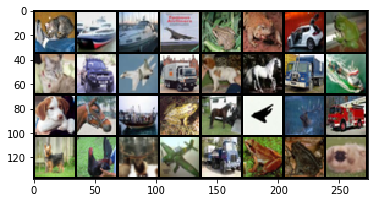

In [508]:
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

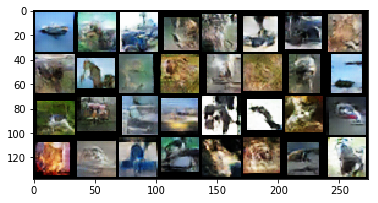

In [509]:
# load the model
model_G.load_state_dict(torch.load('./CW/DCGAN/DCGAN_model_G.pth'))
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:32], nrow=8, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    show(generated)

### Part 2.2 (10 points)

### Train losses curves



Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).


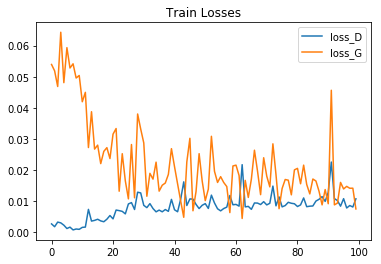

In [510]:
import matplotlib.pyplot as plt
train_losses_D = np.load('./CW/DCGAN/train_losses_D.npy')
train_losses_G = np.load('./CW/DCGAN/train_losses_G.npy')
plt.plot(list(range(0,train_losses_D.shape[0])), train_losses_D, label='loss_D')
plt.plot(list(range(0,train_losses_G.shape[0])), train_losses_G, label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.show()

### Part 2.3 (10 points) 
**Your task:** 

Based on the images created by your generator using the `fixed_noise` vector during training, provide a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse.